# Code for paper

In [1]:
%matplotlib inline
# %config InlineBackend.figure_formats = ['svg']
from scipy.io import loadmat
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mcmc_utils_and_plot import sub_sample_data, scatter_matrix
import time
import math
import scipy.stats as stats 
import scipy.optimize as optimize
import pickle
from ddeint import ddeint

matplotlib.rc('text', usetex = True)
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title

In [2]:
def laplace_approx(initial_guess, logpost):
    def neg_post(x):
        """Negative posteror because optimizer is a minimizer"""
        return -logpost(x)
    
    # Gradient free method to obtain optimum
    res = optimize.minimize(neg_post, initial_guess, method='Nelder-Mead') 
    # Gradient method which also approximates the inverse of the hessian
    res = optimize.minimize(neg_post, res.x)

    map_point = res.x
    cov_approx = res.hess_inv
    return map_point, cov_approx

def autocorrelation(samples, maxlag=100, step=1):  
    # Get the shapes
    ndim = samples.shape[1]
    nsamples = samples.shape[0]    
    
    # Compute the mean
    mean = np.mean(samples, axis=0)
    
    # Compute the denominator, which is variance
    denominator = np.zeros((ndim))
    for ii in range(nsamples):
        denominator = denominator + (samples[ii, :] - mean)**2
    
    lags = np.arange(0, maxlag, step)
    autos = np.zeros((len(lags), ndim))
    for zz, lag in enumerate(lags):
        autos[zz, :] = np.zeros((ndim))
        # compute the covariance between all samples *lag apart*
        for ii in range(nsamples - lag):
            autos[zz,:] = autos[zz, :] + (samples[ii,:]-mean)*(samples[ii + lag,:] -mean)
        autos[zz, :] = autos[zz, :]/denominator
    return lags, autos

In [3]:
class adaptive_metropolis_proposal(object):
    def __init__(self, dim, sd=None, t0=50, max_samples=10000, init_cov=None, eps=1e-8):
        self.dim = dim
        self.sd = sd
        self.init_cov = init_cov
        if sd is None:
            self.sd = (2.4**2) / dim
        if init_cov is None:
            self.init_cov = self.sd * np.eye(dim)

        self.eps = eps
        self.t0 = t0
        self.num_samples = 0
        self.samples = np.zeros((max_samples, self.dim))
        self.current_cov = np.copy(self.init_cov)
        self.current_sqrt = np.linalg.cholesky(self.current_cov)
        self.current_mean = np.zeros(self.dim)
    def sampler1(self, current_sample):
        """Sampler, mean and cov are updated until last accepted sample!"""
        if self.num_samples > 1:
            self.samples[self.num_samples, :] = current_sample
            old_mean = np.copy(self.current_mean)
            k = self.num_samples
            self.current_mean = k/(k+1)*old_mean+1/(k+1)*current_sample
            self.num_samples = self.num_samples + 1
            self.current_cov = ((k-1)/k*self.current_cov + self.sd/k*(self.eps*np.eye(self.dim)+k*np.outer(old_mean,old_mean)
                                -(k+1)*np.outer(self.current_mean,self.current_mean)+np.outer(current_sample,current_sample)))
        else:
            self.num_samples = self.num_samples + 1
            self.current_mean = current_sample       
        if self.num_samples > self.t0:
            self.current_sqrt = np.linalg.cholesky(self.current_cov)
        return current_sample + np.dot(self.current_sqrt, np.random.randn(self.dim))
    def sampler2(self, current_sample,gamma = 0.5):
        """Sampler"""
        self.samples[self.num_samples, :] = current_sample
        return current_sample + gamma*np.dot(self.current_sqrt, np.random.randn(self.dim))
    def logpdf(self, current_sample, candidate,gamma = 1):
        """Logpdf evaluator"""
        delta = candidate - current_sample
        return -0.5 * np.dot(delta, np.linalg.solve(gamma*self.current_cov, delta))

def mh_acceptance_prob(current_target_logpdf, proposed_target_logpdf, current_sample, proposed_sample, proposal_func): 
    prop_reverse = proposal_func(proposed_sample, current_sample)
    prop_forward = proposal_func(current_sample, proposed_sample)
    check = proposed_target_logpdf - current_target_logpdf + prop_reverse - prop_forward
    if check < 0:
        return np.exp(check)
    else:
        return 1

def dr_acceptance_prob(current_target_logpdf,proposed_target_logpdf1,proposed_target_logpdf2, current_sample, proposed_sample1, proposed_sample2, proposal_func1, proposal_func2):
    prop_reverse1 = proposal_func1(proposed_sample1, proposed_sample2)
    prop_forward1 = proposal_func1(current_sample, proposed_sample1)
    
    prop_reverse2 = proposal_func2(proposed_sample2, current_sample)
    prop_forward2 = proposal_func2(current_sample, proposed_sample2)
    
    log_reverse = np.log(1-mh_acceptance_prob(current_target_logpdf,proposed_target_logpdf1, proposed_sample2, proposed_sample1, proposal_func1))
    log_forward = np.log(1-mh_acceptance_prob(current_target_logpdf,proposed_target_logpdf1, current_sample, proposed_sample1, proposal_func1))
    
    
    check = proposed_target_logpdf2 - current_target_logpdf + prop_reverse1 - prop_forward1 + prop_reverse2 - prop_forward2 +log_reverse-log_forward
    if check < 0:
        return np.exp(check)
    else:
        return 1
    
    
def drmcmc(starting_sample, num_samples, target_logpdf, proposal_logpdf1, proposal_logpdf2, proposal_sampler1,proposal_sampler2):
    d = starting_sample.shape[0]
    samples = np.zeros((num_samples, d))
    samples[0, :] = starting_sample
    current_target_logpdf = target_logpdf(samples[0, :])
    
    num_accept = 0
    for ii in range(1, num_samples):
        # propose
        proposed_sample1 = proposal_sampler1(samples[ii-1, :])
        proposed_target_logpdf1 = target_logpdf(proposed_sample1)
        # determine acceptance probability
        a = mh_acceptance_prob(current_target_logpdf, proposed_target_logpdf1, samples[ii-1,:], proposed_sample1, proposal_logpdf1)
        # Accept or reject the sample
        if a == 1: #guaranteed to accept
            samples[ii, :] = proposed_sample1
            current_target_logpdf = proposed_target_logpdf1
            num_accept += 1
        else:
            u = np.random.rand()
            if u < a: # accept
                samples[ii, :] = proposed_sample1
                current_target_logpdf = proposed_target_logpdf1
                num_accept += 1
            else: # propose again
                proposed_sample2 = proposal_sampler2(samples[ii-1, :])
                proposed_target_logpdf2 = target_logpdf(proposed_sample2)
                a = dr_acceptance_prob(current_target_logpdf, proposed_target_logpdf1,proposed_target_logpdf2,samples[ii-1,:], proposed_sample1, proposed_sample2, proposal_logpdf1, proposal_logpdf2)
                if a == 1:
                    samples[ii, :] = proposed_sample2
                    current_target_logpdf = proposed_target_logpdf2
                    num_accept += 1
                else:
                    u = np.random.rand()
                    if u < a: # accept
                        samples[ii, :] = proposed_sample2
                        current_target_logpdf = proposed_target_logpdf2
                        num_accept += 1
                    else: # reject
                        samples[ii, :] = samples[ii-1, :]
    return samples, num_accept / float(num_samples-1)

def gamma_log_prior(param, a = 1.5):
    '''different prior distribution? gamma for tau,alpha,beta,kappa, independent'''
    return np.sum(stats.gamma.logpdf(param, a))

###  For two dimension outputs
def dvdt_predictor(param, dde_fun, Npts, taumax):
    '''if propose tau < 0 or >taumax, then skip simulation just assign out_pred all 0'''
    tsim = np.arange(taumax, (Npts-1)*0.1, 0.1)
    print(len(tsim))
#     tsim = np.linspace(st*0.1+taumax, st*0.1+(Npts-1)*0.1, num=Npts-1-int(taumax/0.1))
    if param[0]<0 or param[0]> taumax:
        out_pred = np.zeros(tsim.shape)
        flag = 1
    else:
        flag = 0
        out_pred = dde_fun(tsim,param)
    return out_pred, flag

def dvdt_predictor_2d(param, dde_fun, Npts, taumax):
    tsim = np.arange(taumax, (Npts-1)*0.1, 0.1)
    if param[0]<0 or param[0]> taumax:
        out_pred = np.zeros((2,len(tsim)))
        flag = 1
    else:
        flag = 0
        out_pred = dde_fun(tsim,param)
    return out_pred, flag
# ### http://gregorygundersen.com/blog/2020/12/12/group-multivariate-normal-pdf/
def multiple_logpdfs(x, means, covs):
    # Thankfully, NumPy broadcasts `eigh`.
    vals, vecs = np.linalg.eigh(covs)

    # Compute the log determinants across the second axis.
    logdets    = np.sum(np.log(vals), axis=1)

    # Invert the eigenvalues.
    valsinvs   = 1./vals
    
    # Add a dimension to `valsinvs` so that NumPy broadcasts appropriately.
    Us         = vecs * np.sqrt(valsinvs)[:, None]
    devs       = x - means

    # Use `einsum` for matrix-vector multiplications across the first dimension.
    devUs      = np.einsum('ni,nij->nj', devs, Us)

    # Compute the Mahalanobis distance by squaring each term and summing.
    mahas      = np.sum(np.square(devUs), axis=1)
    
    # Compute and broadcast scalar normalizers.
    dim        = len(vals[0])
    log2pi     = np.log(2 * np.pi)
    return -0.5 * (dim * log2pi + mahas + logdets)

def dvdt_log_likelihood_2d(param, dde_fun, Npts, taumax, outputs, cov):
    out_pred, flag = dvdt_predictor_2d(param, dde_fun, Npts, taumax)
    # still assume Gaussian noise, var is a vector
    if flag:
        log_like = -math.inf
    else:       
        log_like = np.sum(multiple_logpdfs(out_pred.T,outputs.T,np.tile(cov,(np.shape(out_pred)[1],1,1))))
    return log_like


def dvdt_log_posterior_2d(param, dde_fun, Npts, taumax, outputs, guess_noise_cov,a=1.5):
    return gamma_log_prior(param,a) + dvdt_log_likelihood_2d(param, dde_fun, Npts, taumax, outputs, guess_noise_cov)

0.9926168394946402


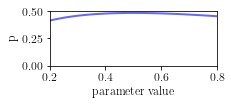

In [4]:
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title
plt.rcParams['text.usetex'] = True
fig, ax = plt.subplots(1, 1, figsize=(3, 1))
# a = 4
# s = 0.2
a = 1.5
s = 1
x = np.linspace(0.2, 0.8, 100)
ax.plot(x, stats.gamma.pdf(x, a, scale = s),'b-', lw=2, alpha=0.6, label='gamma pdf')
# ax.set_title('Gamma Prior')
ax.set_xlabel(r'$\mathrm{parameter\ value}$')
ax.set_xlim((0.2,0.8))
ax.set_ylim((0,0.5))
ax.set_ylabel(r'$\mathrm{p}$')
plt.savefig('figures\gamma_prior.svg')
print(stats.gamma.cdf(6,a))

## $0.001cv^2+0.01bv+0.1a$

In [5]:
amax = 3
amin = -7
kappa = 0.6
alpha = 0.4
beta = 0.5
vmax = 30
hst = 5
hgo = hst+vmax/kappa
P = 50000    # power limit / 75000
m = 1770

a_up = lambda v: np.minimum(amax*np.ones(np.shape(v)),P/m/np.abs(v))
satfun = lambda x,v: (amin<=x)*(x<=a_up(v))*x+(x<amin)*amin+(x>a_up(v))*a_up(v)
satfun_noPL = lambda x: (amin<=x)*(x<=amax)*x+(x<amin)*amin+(x>amax)*amax

Vfun = lambda x: (hst<=x)*(x<=hgo)*kappa*(x-hst)+(x>hgo)*vmax
Wfun =  lambda x: (x<=vmax)*x+(x>vmax)*vmax

# static mapping
def CAV_4dvdt_2d(tsim, param):
    '''param[0] is delay, param[1] is c, param[2] is b, param[3] is a '''
    h,v,vL = observe_fun(tsim)
    hdelay, vdelay, vLdelay = observe_fun(tsim-param[0])
    dhdt = vL-v
#     dvdt = satfun_noPL(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay))-param[1]/1000*v**2-0.01*param[2]*v-0.1*param[3]
    dvdt = (satfun(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay),v)
            -param[1]/1000*v**2-0.01*param[2]*v-0.1*param[3])
    return np.array([dhdt,dvdt])

def CAV_3dvdt_2d(tsim, param):
    '''param[0] is delay, param[1] is c, param[2] is a '''
    h,v,vL = observe_fun(tsim)
    hdelay, vdelay, vLdelay = observe_fun(tsim-param[0])
    dhdt = vL-v
#     dvdt = satfun_noPL(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay))-param[1]/1000*v**2-0.1*param[2]
    dvdt = (satfun(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay),v)
            -param[1]/1000*v**2-0.1*param[2])
    return np.array([dhdt,dvdt])

def CAV_2dvdt_2d(tsim, param):
    '''param[0] is delay, param[1] is c'''
    h,v,vL = observe_fun(tsim)
    hdelay, vdelay, vLdelay = observe_fun(tsim-param[0])
    dhdt = vL-v
#     dvdt = satfun_noPL(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay))-param[1]/1000*v**2
    dvdt = (satfun(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay),v)
            -param[1]/1000*v**2)
    return np.array([dhdt,dvdt])


## simulation
def CAV_4param(Y, t, d, c, b, a):
    '''for simulation'''
    h,v = Y(t)
    hdelay,vdelay = Y(t-d)
    vL = vLfun(t)
    vLdelay = vLfun(t-d)
    dhdt = vL-v
#     dvdt = satfun_noPL(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay))-c/1000*v**2-0.01*b*v-0.1*a
    dvdt = (satfun(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay),v)
            -c/1000*v**2-0.01*b*v-0.1*a)
    return np.array([dhdt,dvdt])

def CAV_3param(Y, t, d, c, a):
    h,v = Y(t)
    hdelay,vdelay = Y(t-d)
    vL = vLfun(t)
    vLdelay = vLfun(t-d)
    dhdt = vL-v
#     dvdt = satfun_noPL(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay))-c/1000*v**2-0.1*a
    dvdt = (satfun(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay),v)
            -c/1000*v**2-0.1*a)
    return np.array([dhdt,dvdt])

def CAV_2param(Y, t, d, c):
    h,v = Y(t)
    hdelay,vdelay = Y(t-d)
    vL = vLfun(t)
    vLdelay = vLfun(t-d)
    dhdt = vL-v
#     dvdt = satfun_noPL(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay))-c/1000*v**2
    dvdt = (satfun(alpha*(Vfun(hdelay)-vdelay)+beta*(Wfun(vLdelay)-vdelay),v)
            -c/1000*v**2)
    return np.array([dhdt,dvdt])


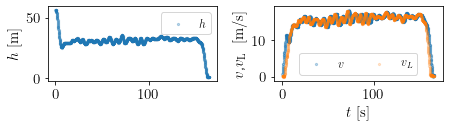

In [6]:
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

h_ave = 20   # average headway in the data       2,7,12,15,18,(22,) (23,45) (26,52)   (28, 55)   (29,69)
# ave lead velocity  2.0, 6.3, 11.4, 14.5, 17.1, 21.7, 20.9, 22.0, 22.3, 25.1
# ave velocity       2.0, 6.5, 11.7, 14.8, 17.6, 22.1, 21.4, 22.8, 23.4, 25.8
# ave headway        8.0, 16.7, 25.6, 30.7,35.7, 44.8, 44.5, 49.7, 52.7, 72.4 (acceleration limit is nonlinear)
fname = 'data\RealAVData\RealAVhstar'+str(h_ave)+'.mat'
data = loadmat(fname)['D']
'''first column is headway of CAV, second column is the speed difference,
third column is the velocity of CAV and last column is the acceleration of CAV.'''
invV = lambda x: (0<=x)*(x<=vmax)*x/kappa+hst+(x>vmax)*hgo

Npts = len(data)
st = 0
data_h = data[st:st+Npts,0]                      # inference from h0
data_vl = data[st:st+Npts,1]+data[st:st+Npts,2]  # input to the system
data_v = data[st:st+Npts,2]                      # or inference from v0
tt = np.linspace(st*0.1, (st+Npts)*0.1, num=Npts)  # reference time
fig,axs = plt.subplots(1, 2, figsize=(6.5, 2.2))
# headway 
axs[0].scatter(tt,data_h, label = '$h$',alpha = 0.3,s = 5)
# axs[0].plot(tt,invV(data_v),'brown',ls='--',label = r'$V^{-1}(v)$')
axs[0].legend(ncol=2)
axs[0].set_ylabel(r'$h\mathrm{\ [m]}$')
# velocity
axs[1].scatter(tt,data_v,label = r'$v$',alpha = 0.3,s = 5)
axs[1].scatter(tt,data_vl,label = r'$v_L$',alpha = 0.2,s = 5)
axs[1].set_ylabel(r'$v$,$v_{\rm L}$ $\mathrm{\ [m/s]}$')
axs[1].set_xlabel('$t\mathrm{\ [s]}$')
axs[1].legend(ncol=2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('figures\hstar'+str(h_ave)+'data.svg')

## Different air drag models
### 4 params

In [37]:
h_ave = 50   # average headway in the data       2,7,12,15,18,(22,) (23,45) (26,52)   (28, 55)   (29,69)
# ave lead velocity  2.0, 6.3, 11.4, 14.5, 17.1, 21.7, 20.9, 22.0, 22.3, 25.1
# ave velocity       2.0, 6.5, 11.7, 14.8, 17.6, 22.1, 21.4, 22.8, 23.4, 25.8
# ave headway        8.0, 16.7, 25.6, 30.7,35.7, 44.8, 44.5, 49.7, 52.7, 72.4 (acceleration limit is nonlinear)
fname = 'data\RealAVData\RealAVhstar'+str(h_ave)+'.mat'
data = loadmat(fname)['D']
'''first column is headway of CAV, second column is the speed difference,
third column is the velocity of CAV and last column is the acceleration of CAV.'''
Npts = len(data)
tau = 0.6
taumax = 6
dt = 0.1
st = 0
data_h = data[st:st+Npts,0]                      # inference from h0
data_vl = data[st:st+Npts,1]+data[st:st+Npts,2]  # input to the system
data_v = data[st:st+Npts,2]                      # or inference from v0
data_dv = np.diff(data_v)/dt
data_dh = np.diff(data_h)/dt
tt = np.linspace(st*0.1, (st+Npts)*0.1, num=Npts)  # reference time
tsim = np.linspace(st*0.1+taumax, st*0.1+(Npts-1)*0.1, num=Npts-1-int(taumax/0.1))   # simulation time
observe_fun = lambda t:np.array([np.interp(t, tt, data_h),np.interp(t, tt, data_v),np.interp(t, tt, data_vl)])

# consider the error both in velocity and acceleration (minimizing MSE_v and MSE_h)
output_2d =np.vstack((data_dh[int(taumax/0.1):],data_dv[int(taumax/0.1):]))

dim = 4
noise_std = np.array([[0.2,0],[0,0.2]])                        # this represent the variance of noise in both states
guess_noise_var = noise_std**2/dt**2                         # this represent the variance of noise in state derivatives

# 2D outputs
post_use_2d = lambda param: dvdt_log_posterior_2d(param, CAV_4dvdt_2d, Npts, taumax, output_2d, guess_noise_var, a=1.5)
guess = stats.gamma.rvs(1.5, size=dim) # random guess
start_time = time.time()
map_point, cov_laplace = laplace_approx(guess, post_use_2d)
print(time.time() - start_time, "seconds")
print(map_point)
print(cov_laplace)

1.5289227962493896 seconds
[0.55933419 0.29660805 0.38363041 0.420796  ]
[[ 1.         -0.5         0.         -0.5       ]
 [-0.5         0.80345264  0.         -0.19654736]
 [ 0.          0.          1.          0.        ]
 [-0.5        -0.19654736  0.          0.80345264]]


In [38]:
num_samples = 10000
dim = 4

initial_sample = map_point
initial_cov = cov_laplace

target_logpdf = lambda param: dvdt_log_posterior_2d(param, CAV_4dvdt_2d, Npts, taumax,output_2d, guess_noise_var, a=1.5)

DRAM = adaptive_metropolis_proposal(dim, sd=None, t0=100, max_samples=num_samples, init_cov=initial_cov, eps=1e-8)
sampler1 = DRAM.sampler1
sampler_logpdf1 = DRAM.logpdf
sampler2 = DRAM.sampler2
sampler_logpdf2 = lambda current_sample, candidate: DRAM.logpdf(current_sample, candidate, gamma = 0.5)
start_time = time.time()
dram_samples, dram_ar = drmcmc(initial_sample, num_samples, target_logpdf, sampler_logpdf1, sampler_logpdf2, sampler1,sampler2)
print(time.time() - start_time, "seconds")
print("Accepted Samples Ratio:", dram_ar)

samples_sub = sub_sample_data(dram_samples, frac_burn=0.5, frac_use=0.5)
mean = np.mean(samples_sub,axis = 0)
median = np.median(samples_sub,axis = 0)
theta_cov = np.cov(samples_sub.T)
theta_std = np.sqrt(np.diag(theta_cov))
theta_quant95 = np.quantile(samples_sub,0.95,axis = 0)
theta_quant05 = np.quantile(samples_sub,0.05,axis = 0)

print('MAP: {}'.format(map_point) )
print('mean: {}'.format(mean))
print('median: {}'.format(median))
# print('covariance:\n', theta_cov)
# print('standard deviation:\n', theta_std)
print('quantile05: {}'.format(theta_quant05))
print('quantile95: {}'.format(theta_quant95))

results_fname = "separate\\power_limit_new\\cba\std1_samples_hdw"+str(h_ave)+"_4param.p"
pickle.dump([dram_samples,dram_ar,map_point,cov_laplace], open(results_fname, "wb" ))
del dram_samples,dram_ar,map_point,cov_laplace

52.6660590171814 seconds
Accepted Samples Ratio: 0.49894989498949893
MAP: [0.55933419 0.29660805 0.38363041 0.420796  ]
mean: [0.76346267 0.32285455 0.6614839  1.01330543]
median: [0.6870236  0.28679019 0.55430412 0.80399538]
quantile05: [0.13393352 0.05577858 0.07732825 0.12000939]
quantile95: [1.69466683 0.72244516 1.6155008  2.60123335]


## 3 params

In [315]:
dim = 3
# 2D outputs
post_use_2d = lambda param: dvdt_log_posterior_2d(param, CAV_3dvdt_2d, Npts, taumax, output_2d, guess_noise_var, a=1.5)

guess = stats.gamma.rvs(1.5, size=dim) # random guess
start_time = time.time()
map_point, cov_laplace = laplace_approx(guess, post_use_2d)
print(time.time() - start_time, "seconds")
print(map_point)
print(cov_laplace)

1.3195722103118896 seconds
[0.57155851 0.16525775 0.19492877]
[[ 4.32119414e-05  1.06891506e-03 -3.77903020e-03]
 [ 1.06891506e-03  3.18463220e-02 -9.38413878e-02]
 [-3.77903020e-03 -9.38413878e-02  3.31465102e-01]]


In [316]:
num_samples = 10000
dim = 3

initial_sample = map_point
initial_cov = cov_laplace

target_logpdf = lambda param: dvdt_log_posterior_2d(param, CAV_3dvdt_2d, Npts, taumax,output_2d, guess_noise_var, a=1.5)

DRAM = adaptive_metropolis_proposal(dim, sd=None, t0=100, max_samples=num_samples, init_cov=initial_cov, eps=1e-8)

sampler1 = DRAM.sampler1
sampler_logpdf1 = DRAM.logpdf
sampler2 = DRAM.sampler2
sampler_logpdf2 = lambda current_sample, candidate: DRAM.logpdf(current_sample, candidate, gamma = 0.5)
start_time = time.time()
dram_samples, dram_ar = drmcmc(initial_sample, num_samples, target_logpdf, sampler_logpdf1, sampler_logpdf2, sampler1,sampler2)
print(time.time() - start_time, "seconds")
print("Accepted Samples Ratio:", dram_ar)

samples_sub = sub_sample_data(dram_samples, frac_burn=0.5, frac_use=0.5)
mean = np.mean(samples_sub,axis = 0)
median = np.median(samples_sub,axis = 0)
theta_cov = np.cov(samples_sub.T)
theta_std = np.sqrt(np.diag(theta_cov))
theta_quant95 = np.quantile(samples_sub,0.95,axis = 0)
theta_quant05 = np.quantile(samples_sub,0.05,axis = 0)

print('MAP: {}'.format(map_point) )
print('mean: {}'.format(mean))
print('median: {}'.format(median))
# print('covariance:\n', theta_cov)
# print('standard deviation:\n', theta_std)
print('quantile05: {}'.format(theta_quant05))
print('quantile95: {}'.format(theta_quant95))

results_fname = "separate\\power_limit_new\\ca\samples_hdw"+str(h_ave)+"_3param.p"
pickle.dump([dram_samples,dram_ar,map_point,cov_laplace], open(results_fname, "wb" ))
del dram_samples,dram_ar,map_point,cov_laplace

42.71801400184631 seconds
Accepted Samples Ratio: 0.48974897489748975
MAP: [0.57155851 0.16525775 0.19492877]
mean: [0.7279272  0.22405507 0.35052925]
median: [0.74360988 0.2006716  0.28676425]
quantile05: [0.5651805  0.03892113 0.04674901]
quantile95: [0.81307877 0.47493783 0.86929856]


## 2 params

In [320]:
dim = 2
# 2D outputs
post_use_2d = lambda param: dvdt_log_posterior_2d(param, CAV_2dvdt_2d, Npts, taumax, output_2d, guess_noise_var, a=1.5)

guess = stats.gamma.rvs(1.5, size=dim) # random guess
start_time = time.time()
map_point, cov_laplace = laplace_approx(guess, post_use_2d)
print(time.time() - start_time, "seconds")
print(map_point)
print(cov_laplace)

0.6648349761962891 seconds
[0.57191667 0.2141455 ]
[[ 0.01890132 -0.01577454]
 [-0.01577454  0.01688659]]


In [321]:
num_samples = 10000
dim = 2

initial_sample = map_point
initial_cov = cov_laplace

target_logpdf = lambda param: dvdt_log_posterior_2d(param, CAV_2dvdt_2d, Npts, taumax,output_2d, guess_noise_var, a=1.5)

DRAM = adaptive_metropolis_proposal(dim, sd=None, t0=100, max_samples=num_samples, init_cov=initial_cov, eps=1e-8)
sampler1 = DRAM.sampler1
sampler_logpdf1 = DRAM.logpdf
sampler2 = DRAM.sampler2
sampler_logpdf2 = lambda current_sample, candidate: DRAM.logpdf(current_sample, candidate, gamma = 0.5)
start_time = time.time()
dram_samples, dram_ar = drmcmc(initial_sample, num_samples, target_logpdf, sampler_logpdf1, sampler_logpdf2, sampler1,sampler2)
print(time.time() - start_time, "seconds")
print("Accepted Samples Ratio:", dram_ar)

samples_sub = sub_sample_data(dram_samples, frac_burn=0.5, frac_use=0.5)
mean = np.mean(samples_sub,axis = 0)
median = np.median(samples_sub,axis = 0)
theta_cov = np.cov(samples_sub.T)
theta_std = np.sqrt(np.diag(theta_cov))
theta_quant95 = np.quantile(samples_sub,0.95,axis = 0)
theta_quant05 = np.quantile(samples_sub,0.05,axis = 0)

print('MAP: {}'.format(map_point) )
print('mean: {}'.format(mean))
print('median: {}'.format(median))
# print('covariance:\n', theta_cov)
# print('standard deviation:\n', theta_std)
print('quantile05: {}'.format(theta_quant05))
print('quantile95: {}'.format(theta_quant95))

results_fname = "separate\\power_limit_new\\c\samples_hdw"+str(h_ave)+"_2param.p"
pickle.dump([dram_samples,dram_ar,map_point,cov_laplace], open(results_fname, "wb" ))
del dram_samples,dram_ar,map_point,cov_laplace

41.716493129730225 seconds
Accepted Samples Ratio: 0.5901590159015901
MAP: [0.57191667 0.2141455 ]
mean: [0.72976309 0.2969349 ]
median: [0.74243222 0.28296551]
quantile05: [0.57220629 0.06544109]
quantile95: [0.80543069 0.58643236]


## Plot

In [322]:
## plot the difference between dataset and different dim
# ave lead velocity  2.0, 6.3, 11.4, 14.5, 17.1, 21.7, 20.9, 22.0, 22.3, 25.1
# ave velocity       2.0, 6.5, 11.7, 14.8, 17.6, 22.1, 21.4, 22.8, 23.4, 25.8
# ave headway        8.0, 16.7, 25.6, 30.7,35.7, 44.8, 44.5, 49.7, 52.7, 72.4 (acceleration limit is nonlinear)
h_collect = (5,10,15,20,25,30,50)
N = np.shape(h_collect)
v_mean = np.zeros(N)
h_mean = np.zeros(N)

dim = 4
N = len(h_collect)
Median_all4 = np.zeros((N,dim))
Mean_all4 = np.zeros((N,dim))
Cov_all4 = np.zeros((N,dim,dim))
Std_all4 = np.zeros((N,dim))
Upb_all4 = np.zeros((N,dim))
Lwb_all4 = np.zeros((N,dim))
MAP_all4 = np.zeros((N,dim))
RMSE_h_mean4= np.zeros(N)
RMSE_v_mean4= np.zeros(N)
RMSE_h_median4= np.zeros(N)
RMSE_v_median4= np.zeros(N)
RMSE_h_map4= np.zeros(N)
RMSE_v_map4= np.zeros(N)

dim = 3
Median_all3 = np.zeros((N,dim))
Mean_all3 = np.zeros((N,dim))
Cov_all3 = np.zeros((N,dim,dim))
Std_all3 = np.zeros((N,dim))
Upb_all3 = np.zeros((N,dim))
Lwb_all3 = np.zeros((N,dim))
MAP_all3 = np.zeros((N,dim))
RMSE_h_mean3= np.zeros(N)
RMSE_v_mean3= np.zeros(N)
RMSE_h_median3= np.zeros(N)
RMSE_v_median3= np.zeros(N)
RMSE_h_map3= np.zeros(N)
RMSE_v_map3= np.zeros(N)

dim = 2
Median_all2 = np.zeros((N,dim))
Mean_all2 = np.zeros((N,dim))
Cov_all2 = np.zeros((N,dim,dim))
Std_all2 = np.zeros((N,dim))
Upb_all2 = np.zeros((N,dim))
Lwb_all2 = np.zeros((N,dim))
MAP_all2 = np.zeros((N,dim))
RMSE_h_mean2= np.zeros(N)
RMSE_v_mean2= np.zeros(N)
RMSE_h_median2= np.zeros(N)
RMSE_v_median2= np.zeros(N)
RMSE_h_map2= np.zeros(N)
RMSE_v_map2= np.zeros(N)



i = 0
for h in h_collect:
    fname = 'data\RealAVData\RealAVhstar'+str(h)+'.mat'
    data = loadmat(fname)['D']
    Npts = len(data)
    dt = 0.1
    st = 0
    data_h = data[st:st+Npts,0]                      # inference from h0
    data_vl = data[st:st+Npts,1]+data[st:st+Npts,2]  # input to the system
    data_v = data[st:st+Npts,2]                      # or inference from v0
    tt = np.linspace(st*0.1, (st+Npts)*0.1, num=Npts)  # reference time
    tsim = np.linspace(st*0.1+taumax, st*0.1+(Npts-1)*0.1, num=Npts-1-int(taumax/0.1))   # simulation time
    observe_fun = lambda t:np.array([np.interp(t, tt, data_h),np.interp(t, tt, data_v),np.interp(t, tt, data_vl)])
    vLfun = lambda t:np.interp(t, tt, data_vl)
    g = lambda t: np.array([np.interp(t, tt, data_h),np.interp(t, tt, data_v)])  # history
    v_mean[i] = np.mean(data_v)
    h_mean[i] = np.mean(data_h)
    
    results_fname = "separate\\power_limit_new\\cba\samples_hdw"+str(h)+"_4param.p"
    [dram_samples,dram_ar,map_point,cov_laplace] = pickle.load(open(results_fname, "rb" ))
    print('v_mean:', v_mean[i],'\n cba, AR: ', dram_ar)
    samples_sub = sub_sample_data(dram_samples, frac_burn=0.5, frac_use=0.7)
    Mean_all4[i,:] = np.mean(samples_sub,axis = 0)
    Median_all4[i,:] = np.median(samples_sub,axis = 0)
    Cov_all4[i,:,:] = np.cov(samples_sub.T)
    Std_all4[i,:] = np.sqrt(np.diag(Cov_all4[i,:,:]))
#     Upb_all4[i,:] = Mean_all4[i,:] + Std_all4[i,:]
#     Lwb_all4[i,:] = np.maximum(Mean_all4[i,:]- Std_all4[i,:],np.zeros(4))
    Upb_all4[i,:] = np.quantile(samples_sub,0.75,axis = 0)
    Lwb_all4[i,:] = np.quantile(samples_sub,0.25,axis = 0)
    MAP_all4[i,:] = map_point
#     yy_mean = ddeint(CAV_4param, g, tsim, fargs= Mean_all4[i,:].tolist())
    yy_median = ddeint(CAV_4param, g, tsim, fargs= Median_all4[i,:].tolist())
    yy_map = ddeint(CAV_4param, g, tsim, fargs=map_point.tolist())
#     RMSE_h_mean4[i] = np.sqrt(np.sum((yy_mean[:,0]-data_h[int(taumax/0.1):-1])**2)/yy_mean.shape[0])
#     RMSE_v_mean4[i] = np.sqrt(np.sum((yy_mean[:,1]-data_v[int(taumax/0.1):-1])**2)/yy_mean.shape[0])
    RMSE_h_median4[i] = np.sqrt(np.sum((yy_median[:,0]-data_h[int(taumax/0.1):-1])**2)/yy_median.shape[0])
    RMSE_v_median4[i] = np.sqrt(np.sum((yy_median[:,1]-data_v[int(taumax/0.1):-1])**2)/yy_median.shape[0])
    RMSE_h_map4[i] = np.sqrt(np.sum((yy_map[:,0]-data_h[int(taumax/0.1):-1])**2)/yy_map.shape[0])
    RMSE_v_map4[i] = np.sqrt(np.sum((yy_map[:,1]-data_v[int(taumax/0.1):-1])**2)/yy_map.shape[0])
    
    results_fname = "separate\\power_limit_new\\ca\samples_hdw"+str(h)+"_3param.p"
    [dram_samples,dram_ar,map_point,cov_laplace] = pickle.load(open(results_fname, "rb" ))
    print(' ca, AR: ', dram_ar)
    samples_sub = sub_sample_data(dram_samples, frac_burn=0.5, frac_use=0.7)
#     Mean_all3[i,:] = np.mean(samples_sub,axis = 0)
    Median_all3[i,:] = np.median(samples_sub,axis = 0)
    Cov_all3[i,:,:] = np.cov(samples_sub.T)
    Std_all3[i,:] = np.sqrt(np.diag(Cov_all3[i,:,:]))
#     Upb_all3[i,:] = Mean_all3[i,:] + Std_all3[i,:]
#     Lwb_all3[i,:] = np.maximum(Mean_all3[i,:]- Std_all3[i,:],np.zeros(3))
    Upb_all3[i,:] = np.quantile(samples_sub,0.75,axis = 0)
    Lwb_all3[i,:] = np.quantile(samples_sub,0.25,axis = 0)
    MAP_all3[i,:] = map_point
#     yy_mean = ddeint(CAV_3param, g, tsim, fargs= Mean_all3[i,:].tolist())
    yy_median = ddeint(CAV_3param, g, tsim, fargs= Median_all3[i,:].tolist())
    yy_map = ddeint(CAV_3param, g, tsim, fargs=map_point.tolist())
#     RMSE_h_mean3[i] = np.sqrt(np.sum((yy_mean[:,0]-data_h[int(taumax/0.1):-1])**2)/yy_mean.shape[0])
#     RMSE_v_mean3[i] = np.sqrt(np.sum((yy_mean[:,1]-data_v[int(taumax/0.1):-1])**2)/yy_mean.shape[0])
    RMSE_h_median3[i] = np.sqrt(np.sum((yy_median[:,0]-data_h[int(taumax/0.1):-1])**2)/yy_median.shape[0])
    RMSE_v_median3[i] = np.sqrt(np.sum((yy_median[:,1]-data_v[int(taumax/0.1):-1])**2)/yy_median.shape[0])
    RMSE_h_map3[i] = np.sqrt(np.sum((yy_map[:,0]-data_h[int(taumax/0.1):-1])**2)/yy_map.shape[0])
    RMSE_v_map3[i] = np.sqrt(np.sum((yy_map[:,1]-data_v[int(taumax/0.1):-1])**2)/yy_map.shape[0])
    
    results_fname = "separate\\power_limit_new\\c\samples_hdw"+str(h)+"_2param.p"
    [dram_samples,dram_ar,map_point,cov_laplace] = pickle.load(open(results_fname, "rb" ))
    print(' c, AR: ', dram_ar)
    samples_sub = sub_sample_data(dram_samples, frac_burn=0.5, frac_use=0.7)
#     Mean_all2[i,:] = np.mean(samples_sub,axis = 0)
    Median_all2[i,:] = np.median(samples_sub,axis = 0)
    Cov_all2[i,:,:] = np.cov(samples_sub.T)
    Std_all2[i,:] = np.sqrt(np.diag(Cov_all2[i,:,:]))
#     Upb_all2[i,:] = Mean_all2[i,:] + Std_all2[i,:]
#     Lwb_all2[i,:] = np.maximum(Mean_all2[i,:]- Std_all2[i,:],np.zeros(2))
    Upb_all2[i,:] = np.quantile(samples_sub,0.75,axis = 0)
    Lwb_all2[i,:] = np.quantile(samples_sub,0.25,axis = 0)
    MAP_all2[i,:] = map_point
#     yy_mean = ddeint(CAV_2param, g, tsim, fargs= Mean_all2[i,:].tolist())
    yy_median = ddeint(CAV_2param, g, tsim, fargs= Median_all2[i,:].tolist())
    yy_map = ddeint(CAV_2param, g, tsim, fargs=map_point.tolist())
#     RMSE_h_mean2[i] = np.sqrt(np.sum((yy_mean[:,0]-data_h[int(taumax/0.1):-1])**2)/yy_mean.shape[0])
#     RMSE_v_mean2[i] = np.sqrt(np.sum((yy_mean[:,1]-data_v[int(taumax/0.1):-1])**2)/yy_mean.shape[0])
    RMSE_h_median2[i] = np.sqrt(np.sum((yy_median[:,0]-data_h[int(taumax/0.1):-1])**2)/yy_median.shape[0])
    RMSE_v_median2[i] = np.sqrt(np.sum((yy_median[:,1]-data_v[int(taumax/0.1):-1])**2)/yy_median.shape[0])
    RMSE_h_map2[i] = np.sqrt(np.sum((yy_map[:,0]-data_h[int(taumax/0.1):-1])**2)/yy_map.shape[0])
    RMSE_v_map2[i] = np.sqrt(np.sum((yy_map[:,1]-data_v[int(taumax/0.1):-1])**2)/yy_map.shape[0])
    i = i+1


v_mean: 2.033521695257316 
 cba, AR:  0.5001500150015001
 ca, AR:  0.5613561356135613
 c, AR:  0.6142614261426143
v_mean: 6.543597194388778 
 cba, AR:  0.555055505550555
 ca, AR:  0.6101610161016101
 c, AR:  0.7152715271527152
v_mean: 11.72158131176999 
 cba, AR:  0.5005500550055005
 ca, AR:  0.5589558955895589
 c, AR:  0.6342634263426342
v_mean: 14.852660606060606 
 cba, AR:  0.4673467346734673
 ca, AR:  0.48974897489748975
 c, AR:  0.5901590159015901
v_mean: 17.56482084690554 
 cba, AR:  0.5252525252525253
 ca, AR:  0.5852585258525853
 c, AR:  0.6437643764376437
v_mean: 22.14625687156422 
 cba, AR:  0.5083508350835083
 ca, AR:  0.5728572857285729
 c, AR:  0.6120612061206121
v_mean: 25.84456611570248 
 cba, AR:  0.5531553155315532
 ca, AR:  0.6064606460646065
 c, AR:  0.7101710171017102


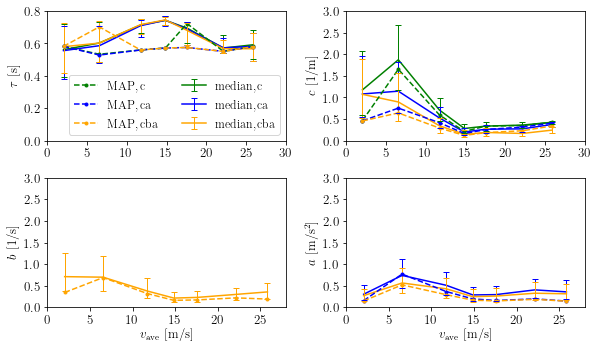

In [330]:
plt.rc('font', size=13)          # controls default text sizes
plt.rc('axes', titlesize=13)     # fontsize of the axes title
plt.rc('axes', labelsize=13)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

fig, axs = plt.subplots(2, 2, figsize=(8.5, 5.5))
axs[0,0].plot(v_mean, MAP_all2[:,0],'green',ls ='--',marker = '.',label='$\mathrm{MAP, c}$')
axs[0,0].plot(v_mean, MAP_all3[:,0],'blue',ls ='--',marker = '.',label='$\mathrm{MAP, ca}$')
axs[0,0].plot(v_mean, MAP_all4[:,0],'orange',ls ='--',marker = '.',label='$\mathrm{MAP, cba}$')
axs[0,0].errorbar(v_mean, Median_all2[:,0], yerr=np.vstack([Median_all2[:,0]-Lwb_all2[:,0], Upb_all2[:,0]-Median_all2[:,0]]),c='green',
                  ecolor='green',elinewidth=1, capsize=3, barsabove=True,label='$\mathrm{median, c}$')
axs[0,0].errorbar(v_mean, Median_all3[:,0], yerr=np.vstack([Median_all3[:,0]-Lwb_all3[:,0], Upb_all3[:,0]-Median_all3[:,0]]),c='blue',
                  ecolor='blue',elinewidth=1, capsize=3, barsabove=True,label='$\mathrm{median, ca}$')
axs[0,0].errorbar(v_mean, Median_all4[:,0], yerr=np.vstack([Median_all4[:,0]-Lwb_all4[:,0], Upb_all4[:,0]-Median_all4[:,0]]),c='orange',
                  ecolor='orange',elinewidth=1, capsize=3, barsabove=True,label='$\mathrm{median, cba}$')
# axs[0,0].set_ylim([0,3])
# axs[0,0].set_yticks([0,0.5,1,1.5,2,2.5,3])
axs[0,0].set_ylim([0,0.8])
axs[0,0].set_yticks([0,0.2,0.4,0.6,0.8])
axs[0,0].set_xlim([0,30])
axs[0,0].legend(ncol = 2)
axs[0,0].set_ylabel(r'$\tau$ $\mathrm{[s]}$')

axs[0,1].plot(v_mean, MAP_all2[:,1],'green',ls ='--',marker = '.',label='c, MAP')
axs[0,1].plot(v_mean, MAP_all3[:,1],'blue',ls ='--',marker = '.',label='ca, MAP')
axs[0,1].plot(v_mean, MAP_all4[:,1],'orange',ls ='--',marker = '.',label='cba, MAP')
axs[0,1].errorbar(v_mean, Median_all2[:,1], yerr=np.vstack([Median_all2[:,1]-Lwb_all2[:,1], Upb_all2[:,1]-Median_all2[:,1]]),c='green',
                  ecolor='green',elinewidth=1, capsize=3, barsabove=True,label='$\mathrm{median, c}$')
axs[0,1].errorbar(v_mean, Median_all3[:,1], yerr=np.vstack([Median_all3[:,1]-Lwb_all3[:,1], Upb_all3[:,1]-Median_all3[:,1]]),c='blue',
                  ecolor='blue',elinewidth=1, capsize=3, barsabove=True,label='$\mathrm{median, ca}$')
axs[0,1].errorbar(v_mean, Median_all4[:,1], yerr=np.vstack([Median_all4[:,1]-Lwb_all4[:,1], Upb_all4[:,1]-Median_all4[:,1]]),c='orange',
                  ecolor='orange',elinewidth=1, capsize=3, barsabove=True,label='$\mathrm{median, cba}$')
axs[0,1].set_ylim([0,3])
axs[0,1].set_xlim([0,30])
axs[0,1].set_yticks([0,0.5,1,1.5,2,2.5,3])
axs[0,1].set_ylabel('$c$ $\mathrm{[1/m]}$')

axs[1,0].plot(v_mean, MAP_all4[:,2],'orange',ls ='--',marker = '.',label='MAP, cba')
axs[1,0].errorbar(v_mean,  Median_all4[:,2], yerr=np.vstack([Median_all4[:,2]-Lwb_all4[:,2], Upb_all4[:,2]-Median_all4[:,2]]),c='orange',ecolor='orange',
                  elinewidth=1, capsize=3, barsabove=True,label='$\mathrm{median, cba}$')
axs[1,0].set_ylabel('$b$ $\mathrm{[1/s]}$')
axs[1,0].set_ylim([0,3])
axs[1,0].set_yticks([0,0.5,1,1.5,2,2.5,3])
axs[1,0].set_xlim([0,28])
axs[1,0].set_xlabel(r'$v_{\rm ave}$ $\mathrm{[m/s]}$')

axs[1,1].plot(v_mean, MAP_all3[:,2],'blue',ls ='--',marker = '.',label='MAP, ca')
axs[1,1].plot(v_mean, MAP_all4[:,3],'orange',ls ='--',marker = '.',label='MAP, cba')
axs[1,1].errorbar(v_mean, Median_all3[:,2], yerr=np.vstack([Median_all3[:,2]-Lwb_all3[:,2], Upb_all3[:,2]-Median_all3[:,2]]),c='blue',
                  ecolor='blue',elinewidth=1, capsize=3, barsabove=True,label='$\mathrm{median, ca}$')
axs[1,1].errorbar(v_mean, Median_all4[:,3], yerr=np.vstack([Median_all4[:,3]-Lwb_all4[:,3], Upb_all4[:,3]-Median_all4[:,3]]),c='orange',
                  ecolor='orange',elinewidth=1, capsize=3, barsabove=True,label='$\mathrm{median, cba}$')
axs[1,1].set_ylim([0,3])
axs[1,1].set_xlim([0,28])
axs[1,1].set_yticks([0,0.5,1,1.5,2,2.5,3])
axs[1,1].set_ylabel('$a$ $\mathrm{[m/s^2]}$')
axs[1,1].set_xlabel(r'$v_{\rm ave}$ $\mathrm{[m/s]}$')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('figures\errorbars_sep_noPL.svg')

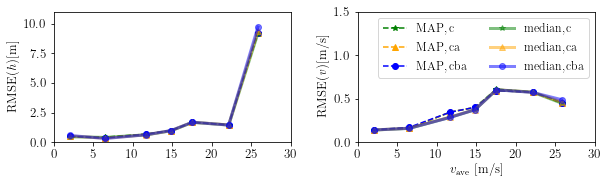

In [329]:
plt.rc('font', size=13)          # controls default text sizes
plt.rc('axes', titlesize=13)     # fontsize of the axes title
plt.rc('axes', labelsize=13)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

fig, axs = plt.subplots(1, 2, figsize=(8.5, 3))
axs[0].plot(v_mean, RMSE_h_map2,'green',ls='--',marker = '*',label='$\mathrm{MAP, c}$')
axs[0].plot(v_mean, RMSE_h_map3,'orange',ls='--',marker = '^',label='$\mathrm{MAP, ca}$')
axs[0].plot(v_mean, RMSE_h_map4,'blue',ls='--',marker = 'o',label='$\mathrm{MAP, cba}$')
axs[0].plot(v_mean, RMSE_h_median2,'green',linewidth=3, alpha=0.5,marker = '*',label='$\mathrm{median, c}$')
axs[0].plot(v_mean, RMSE_h_median3,'orange',linewidth=3, alpha=0.5,marker = '^',label='$\mathrm{median, ca}$')
axs[0].plot(v_mean, RMSE_h_median4,'blue',linewidth=3, alpha=0.5,marker = 'o',label='$\mathrm{median, cba}$')
axs[0].set_xlim([0,30])
axs[0].set_xticks((0,5,10,15,20,25,30))
axs[0].set_ylim([0,11])
axs[0].set_xlabel(r'$v_{\rm ave}$ $\mathrm{[m/s]}$')
axs[0].set_ylabel('$\mathrm{RMSE(\mathit{h}) [m]}$')

axs[1].plot(v_mean, RMSE_v_map2,'green',ls='--',marker = '*',label='$\mathrm{MAP, c}$')
axs[1].plot(v_mean, RMSE_v_map3,'orange',ls='--',marker = '^',label='$\mathrm{MAP, ca}$')
axs[1].plot(v_mean, RMSE_v_map4,'blue',ls='--',marker = 'o',label='$\mathrm{MAP, cba}$')
axs[1].plot(v_mean, RMSE_v_median2,'green',marker = '*',linewidth=3, alpha=0.5,label='$\mathrm{median, c}$')
axs[1].plot(v_mean, RMSE_v_median3,'orange',marker = '^',linewidth=3, alpha=0.5,label='$\mathrm{median, ca}$')
axs[1].plot(v_mean, RMSE_v_median4,'blue',marker = 'o',linewidth=3, alpha=0.5,label='$\mathrm{median, cba}$')
axs[1].set_xlim([0,30])
axs[1].set_xticks((0,5,10,15,20,25,30))
axs[1].set_ylim([0,1.5])
axs[1].legend(ncol = 2)
axs[1].set_ylabel(r'$\mathrm{RMSE(\mathit{v}) [m/s]}$')
axs[1].set_xlabel(r'$v_{\rm ave}$ $\mathrm{[m/s]}$')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('figures\RMSE_sep_noPL.svg')

MAP: [0.55933419 0.29660805 0.38363041 0.420796  ]
mean: [0.76571586 0.3235901  0.66112977 1.01394075]
median: [0.6870236  0.28949718 0.55821033 0.8058237 ]
quantile05: [0.13397631 0.04990958 0.07660135 0.119944  ]
quantile95: [1.69229336 0.72649979 1.61893542 2.60520473]


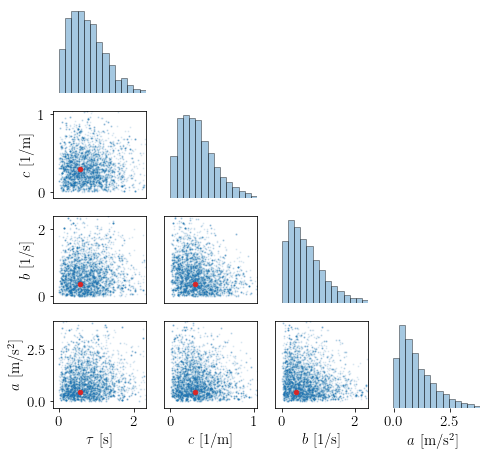

In [39]:
## plot MAP/Mean/STD Simu
h_ave = 50
dim = 4
fname = 'data\RealAVData\RealAVhstar'+str(h_ave)+'.mat'
data = loadmat(fname)['D']
'''first column is headway of CAV, second column is the speed difference,
third column is the velocity of CAV and last column is the acceleration of CAV.'''
Npts = len(data)
dt = 0.1
st = 0
data_h = data[st:st+Npts,0]                      # inference from h0
data_vl = data[st:st+Npts,1]+data[st:st+Npts,2]  # input to the system
data_v = data[st:st+Npts,2]                      # or inference from v0
data_dv = np.diff(data_v)/dt
data_dh = np.diff(data_h)/dt
tt = np.linspace(st*0.1, (st+Npts)*0.1, num=Npts)  # reference time
tsim = np.linspace(st*0.1+taumax, st*0.1+(Npts-1)*0.1, num=Npts-1-int(taumax/0.1))   # simulation time
observe_fun = lambda t:np.array([np.interp(t, tt, data_h),np.interp(t, tt, data_v),np.interp(t, tt, data_vl)])

# consider the error both in velocity and acceleration (minimizing MSE_v and MSE_h)
output_2d =np.vstack((data_dh[int(taumax/0.1):],data_dv[int(taumax/0.1):]))


results_fname = "separate\\power_limit_new\\cba\std1_samples_hdw"+str(h_ave)+"_"+str(dim)+"param.p"
# results_fname = "separate\\no_power_limit\\001b01a\samples_out2_hdw"+str(h_ave)+"_"+str(dim)+"param.p"
[dram_samples,dram_ar,map_point,cov_laplace] = pickle.load(open(results_fname, "rb" ))
samples_sub = sub_sample_data(dram_samples, frac_burn=0.5, frac_use=0.9)

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

fig, axs, gs = scatter_matrix([samples_sub],labels=
                              [r'$\tau$ $\mathrm{[s]}$', '$c$ $\mathrm{[1/m]}$', '$b$ $\mathrm{[1/s]}$', '$a$ $\mathrm{[m/s^2]}$'], 
                              hist_plot=False, gamma=0.1, nbins=70)
# axs[0].set_xlim((0.4,0.8))
# axs[1].set_xlim((0,0.6))
# axs[2].set_xlim((0,1.5))
# axs[3].set_xlim((0,1))
# axs[3].set_xticks((0,0.5,1))

# axs[4].set_ylim((0,0.6)) # top tau-c
# axs[4].set_yticks((0,0.2,0.4,0.6))
# axs[4].set_xlim((0.4,0.8))
axs[4].scatter(map_point[0],map_point[1],s=20,c = '#d62728',zorder=5000)

# axs[8].set_ylim((0,1.5)) # mid 1  tau-b
# axs[8].set_yticks((0,0.5,1,1.5))
# axs[8].set_xlim((0.4,0.8))
axs[8].scatter(map_point[0],map_point[2],s=20,c = '#d62728',zorder=5000)

# axs[9].set_ylim((0,1.5)) # mid  c-b
# axs[9].set_xlim((0,0.6))
axs[9].scatter(map_point[1],map_point[2],s=20,c = '#d62728',zorder=5000)


# axs[12].set_ylim((0,1)) # bot 1 tau-a
# axs[12].set_yticks((0,0.5,1))
# axs[12].set_xlim((0.4,0.8))
# axs[12].set_xticks((0.4,0.6,0.8))
axs[12].scatter(map_point[0],map_point[3],s=20,c = '#d62728',zorder=5000)

# axs[13].set_ylim((0,1))
# axs[13].set_xlim((0,0.6)) # bot 2 c-a
# axs[13].set_xticks((0,0.2,0.4,0.6)) # bot 2
axs[13].scatter(map_point[1],map_point[3],s=20,c = '#d62728',zorder=5000)

# axs[14].set_ylim((0,1))
# axs[14].set_xlim((0,1.5)) # bot 3 b-a
# axs[14].set_xticks((0,0.5,1,1.5)) # bot 3
axs[14].scatter(map_point[2],map_point[3],s=20,c = '#d62728',zorder=5000)

fig.set_size_inches(7,7)
plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.savefig('figures\hstar'+str(h_ave)+"_"+str(dim)+'param_sep_noPL.svg')


# fig, axs = plt.subplots(2,2, figsize=(8,4))
# axs[0,0].plot(samples_sub[:, 0], '-k',lw=0.5)
# axs[0,0].set_ylabel(r'$\tau$ $\mathrm{[s]}$', fontsize=14)
# # axs[0,0].set_yticks((0.4,0.6,0.8))

# axs[0,1].plot(samples_sub[:, 1], '-k',lw=0.5)
# axs[0,1].set_ylabel(r'$c$ $\mathrm{[1/m]}$', fontsize=14)
# # axs[0,1].set_yticks((0,0.2,0.4,0.6))

# axs[1,0].plot(samples_sub[:, 2], '-k',lw=0.5)
# axs[1,0].set_ylabel('$b$ $\mathrm{[1/s]}$', fontsize=14)
# # axs[1,0].set_yticks((0,0.5,1,1.5))
# axs[1,0].set_xlabel('$\mathrm{Sample Number}$', fontsize=14)

# axs[1,1].plot(samples_sub[:, 3], '-k',lw=0.5)
# # axs[1,1].set_yticks((0,0.5,1))
# axs[1,1].set_ylabel('$a$ $\mathrm{[m/s^2]}$', fontsize=14)
# axs[1,1].set_xlabel('$\mathrm{Sample Number}$', fontsize=14)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig('figures\hstar'+str(h_ave)+"_"+str(dim)+'_inspect_sep_noPL.svg')

# marginal_like_c = 0
# for i in range(5):
#     like_log = dvdt_log_likelihood_2d(samples_sub[i,:],CAV_4dvdt_2d, Npts, taumax,output_2d, guess_noise_var)
#     print(np.exp(like_log))
#     marginal_like_c = marginal_like_c + np.exp(like_log)
mean = np.mean(samples_sub,axis = 0)
median = np.median(samples_sub,axis = 0)
theta_cov = np.cov(samples_sub.T)
theta_std = np.sqrt(np.diag(theta_cov))
theta_quant95 = np.quantile(samples_sub,0.95,axis = 0)
theta_quant05 = np.quantile(samples_sub,0.05,axis = 0)

print('MAP: {}'.format(map_point) )
print('mean: {}'.format(mean))
print('median: {}'.format(median))
# print('covariance:\n', theta_cov)
# print('standard deviation:\n', theta_std)
print('quantile05: {}'.format(theta_quant05))
print('quantile95: {}'.format(theta_quant95))

In [347]:
vLfun = lambda t:np.interp(t, tt, data_vl)
g = lambda t: np.array([np.interp(t, tt, data_h),np.interp(t, tt, data_v)])  # history
yy_median = ddeint(CAV_4param, g, tsim, fargs=median.tolist())
yy_upb = ddeint(CAV_4param, g, tsim, fargs=theta_quant95.tolist())
yy_lwb = ddeint(CAV_4param, g, tsim, fargs=theta_quant05.tolist())
MSE_h = np.sum((yy_median[:,0]-data_h[int(taumax/0.1):-1])**2)/yy_median.shape[0]
MSE_v = np.sum((yy_median[:,1]-data_v[int(taumax/0.1):-1])**2)/yy_median.shape[0]

yy_map = ddeint(CAV_4param, g, tsim, fargs=map_point.tolist())
MSE_h_map = np.sum((yy_map[:,0]-data_h[int(taumax/0.1):-1])**2)/yy_map.shape[0]
MSE_v_map = np.sum((yy_map[:,1]-data_v[int(taumax/0.1):-1])**2)/yy_map.shape[0]

0.3240799970705632
0.1613736778775827
0.35738396077642637
0.17312529740110028


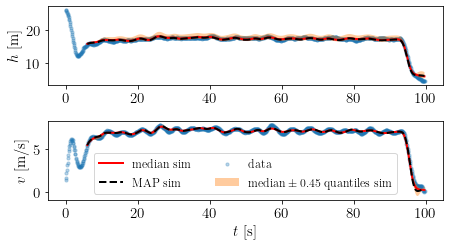

In [348]:
print(np.sqrt(MSE_h))
print(np.sqrt(MSE_v))
matplotlib.rc('text', usetex = True)
fig,axs = plt.subplots(2, 1, figsize=(6.5, 4))
# headway 
axs[0].scatter(tt,data_h, label = 'data',alpha = 0.3,s = 10)
axs[0].plot(tsim,yy_median[:,0],'red',ls ='-', label = 'mean simulation',linewidth=2)
axs[0].fill_between(tsim,yy_upb[:,0], yy_lwb[:,0],label = r'$\mathrm{median} \pm \mathrm{0.45\ quantiles\ sim}$', alpha=0.4)
axs[0].plot(tsim,yy_map[:,0],'black',ls ='--', label = 'MAP simulation',linewidth=2)
# axs[0].set_title(r'$\tau$ = {:.2f}$\pm2${:.2f}, $a$ = {:.2f}$\pm 2${:.2f}, $b$ = {:.3f}$\pm2${:.3f}, $c$ = {:.2f}$\pm2${:.2f}'.format(
#     theta[0],theta_std[0],theta[3],theta_std[3],theta[2],theta_std[2],theta[1],theta_std[1]))
axs[0].set_ylabel(r'$h\mathrm{\ [m]}$')
# velocity
axs[1].scatter(tt,data_v,label = r'$\mathrm{data}$',alpha = 0.3,s = 10)
axs[1].plot(tsim,yy_median[:,1], 'red', ls ='-', label = r'$\mathrm{median\ sim}$',linewidth=2)
axs[1].fill_between(tsim,yy_upb[:,1], yy_lwb[:,1],label = r'$\mathrm{median} \pm \mathrm{0.45\ quantiles\ sim}$',alpha=0.4)
axs[1].set_ylabel(r'$v\mathrm{\ [m/s]}$')
axs[1].plot(tsim,yy_map[:,1], 'black', ls ='--',label = r'$\mathrm{MAP\ sim}$',linewidth=2)
axs[1].set_xlabel(r'$t\mathrm{\ [s]}$')
# axs[1].set_title(r'$h^*$ = {} m; mean $MSE_h$ = {:.3f},$MSE_v$ = {:.3f}; MAP $MSE_h$ = {:.3f},$MSE_v$ = {:.3f}'.format(h_ave, MSE_h,MSE_v,MSE_h_map,MSE_v_map))
axs[1].legend(ncol=2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('figures\hstar'+str(h_ave)+'_'+str(dim)+'param_simu_sep_noPL.svg')

print(np.sqrt(MSE_h_map))
print(np.sqrt(MSE_v_map))

0.6064606460646065
MAP: [0.58051679 0.40634756 0.14544461]
mean: [0.57934229 0.37076284 0.45045278]
median: [0.58216169 0.37371658 0.35761515]
quantile05: [0.36385873 0.24025922 0.05142434]
quantile95: [0.80669121 0.48581625 1.14286656]


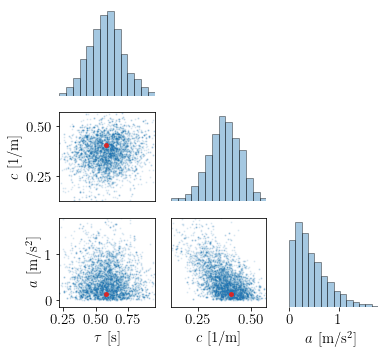

In [7]:
## plot MAP/Mean/STD Simu
h_ave = 50
fname = 'data\RealAVData\RealAVhstar'+str(h_ave)+'.mat'
data = loadmat(fname)['D']
'''first column is headway of CAV, second column is the speed difference,
third column is the velocity of CAV and last column is the acceleration of CAV.'''
Npts = len(data)
dt = 0.1
st = 0
taumax = 6
data_h = data[st:st+Npts,0]                      # inference from h0
data_vl = data[st:st+Npts,1]+data[st:st+Npts,2]  # input to the system
data_v = data[st:st+Npts,2]                      # or inference from v0
data_dv = np.diff(data_v)/dt
data_dh = np.diff(data_h)/dt
tt = np.linspace(st*0.1, (st+Npts)*0.1, num=Npts)  # reference time
tsim = np.linspace(st*0.1+taumax, st*0.1+(Npts-1)*0.1, num=Npts-1-int(taumax/0.1))   # simulation time
observe_fun = lambda t:np.array([np.interp(t, tt, data_h),np.interp(t, tt, data_v),np.interp(t, tt, data_vl)])

dim = 3
results_fname = "separate\\power_limit_new\\ca\samples_hdw"+str(h_ave)+"_"+str(dim)+"param.p"

[dram_samples,dram_ar,map_point,cov_laplace] = pickle.load(open(results_fname, "rb" ))
print(dram_ar)
samples_sub = sub_sample_data(dram_samples, frac_burn=0.5, frac_use=0.9)

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

fig, axs, gs = scatter_matrix([samples_sub], labels=
                              [r'$\tau$ $\mathrm{[s]}$', '$c$ $\mathrm{[1/m]}$', '$a$ $\mathrm{[m/s^2]}$'], 
                              hist_plot=False, gamma=0.1, nbins=70)
# axs[0].set_xlim((0.4,0.8))     # tau
# axs[1].set_xlim((0,0.6))       # c
# axs[2].set_xlim((0,0.6))         # a
# axs[2].set_xticks((0,0.2,0.4,0.6))

# axs[3].set_ylim((0,0.6)) # top tau-c
# axs[3].set_yticks((0,0.2,0.4,0.6))
# axs[3].set_xlim((0.4,0.8))
axs[3].scatter(map_point[0],map_point[1],s=15,c = '#d62728',zorder=5000)
axs[3].set_rasterized(True)

# axs[6].set_ylim((0,0.6)) # mid 1  tau-a
# axs[6].set_yticks((0,0.2,0.4,0.6))
# axs[6].set_xlim((0.4,0.8))
axs[6].scatter(map_point[0],map_point[2],s=15,c = '#d62728',zorder=5000)
axs[6].set_rasterized(True)

# axs[7].set_ylim((0,0.6)) # mid  c-a
# axs[7].set_xlim((0,0.6))
# axs[7].set_xticks((0,0.2,0.4,0.6))
axs[7].scatter(map_point[1],map_point[2],s=15,c = '#d62728',zorder=5000)
axs[7].set_rasterized(True)



fig.set_size_inches(5.5,5.5)
plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.savefig('figures\marginal_'+str(dim)+'param_com_PL.svg',dpi=500)

mean = np.mean(samples_sub,axis = 0)
median = np.median(samples_sub,axis = 0)
theta_cov = np.cov(samples_sub.T)
theta_std = np.sqrt(np.diag(theta_cov))
theta_quant95 = np.quantile(samples_sub,0.95,axis = 0)
theta_quant05 = np.quantile(samples_sub,0.05,axis = 0)
print('MAP: {}'.format(map_point) )
print('mean: {}'.format(mean))
print('median: {}'.format(median))
print('quantile05: {}'.format(theta_quant05))
print('quantile95: {}'.format(theta_quant95))


In [ ]:
yy_median = ddeint(CAV_3param, g, tsim, fargs=median.tolist())
yy_upb = ddeint(CAV_3param, g, tsim, fargs=theta_quant95.tolist())
yy_lwb = ddeint(CAV_3param, g, tsim, fargs=theta_quant05.tolist())
MSE_h = np.sum((yy_median[:,0]-data_h[int(taumax/0.1):-1])**2)/yy_median.shape[0]
MSE_v = np.sum((yy_median[:,1]-data_v[int(taumax/0.1):-1])**2)/yy_median.shape[0]

yy_map = ddeint(CAV_3param, g, tsim, fargs=map_point.tolist())
MSE_h_map = np.sum((yy_map[:,0]-data_h[int(taumax/0.1):-1])**2)/yy_map.shape[0]
MSE_v_map = np.sum((yy_map[:,1]-data_v[int(taumax/0.1):-1])**2)/yy_map.shape[0]

print(np.sqrt(MSE_h))
print(np.sqrt(MSE_v))
matplotlib.rc('text', usetex = True)
fig,axs = plt.subplots(2, 1, figsize=(6.5, 4))
# headway 
axs[0].scatter(tt,data_h, label = 'data',alpha = 0.3,s = 10)
axs[0].plot(tsim,yy_median[:,0],'red',ls ='-', label = 'mean simulation',linewidth=2)
axs[0].fill_between(tsim,yy_upb[:,0], yy_lwb[:,0],label = r'$\pm 2std$', alpha=0.4)
axs[0].plot(tsim,yy_map[:,0],'black',ls ='--', label = 'MAP simulation',linewidth=2)
# axs[0].set_title(r'$\tau$ = {:.2f}$\pm2${:.2f}, $a$ = {:.2f}$\pm 2${:.2f}, $b$ = {:.3f}$\pm2${:.3f}, $c$ = {:.2f}$\pm2${:.2f}'.format(
#     theta[0],theta_std[0],theta[3],theta_std[3],theta[2],theta_std[2],theta[1],theta_std[1]))
axs[0].set_ylabel(r'$h\mathrm{\ [m]}$')
# velocity
axs[1].scatter(tt,data_v,label = r'$\mathrm{data}$',alpha = 0.3,s = 10)
axs[1].plot(tsim,yy_median[:,1], 'red', ls ='-', label = r'$\mathrm{median\ sim}$',linewidth=2)
axs[1].fill_between(tsim,yy_upb[:,1], yy_lwb[:,1],label = r'$\mathrm{median} \pm \mathrm{0.45 quantile\ sim}$',alpha=0.4)
axs[1].set_ylabel(r'$v\mathrm{\ [m/s]}$')
axs[1].plot(tsim,yy_map[:,1], 'black', ls ='--',label = r'$\mathrm{MAP\ sim}$',linewidth=2)
axs[1].set_xlabel(r'$t\mathrm{\ [s]}$')
# axs[1].set_title(r'$h^*$ = {} m; mean $MSE_h$ = {:.3f},$MSE_v$ = {:.3f}; MAP $MSE_h$ = {:.3f},$MSE_v$ = {:.3f}'.format(h_ave, MSE_h,MSE_v,MSE_h_map,MSE_v_map))
axs[1].legend(ncol=2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('figures\hstar'+str(h_ave)+'_'+str(dim)+'param_simu_com.svg')

## 500 derivatives

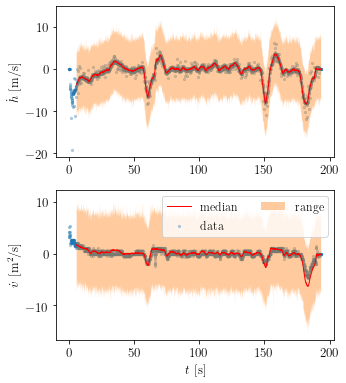

In [11]:
dim = 4
h_ave = 50
taumax = 6
fname = 'data\RealAVData\RealAVhstar'+str(h_ave)+'.mat'
data = loadmat(fname)['D']
'''first column is headway of CAV, second column is the speed difference,
third column is the velocity of CAV and last column is the acceleration of CAV.'''
Npts_single = len(data)
dt = 0.1
st = 0
data_h_single = data[st:st+Npts_single,0]                      # inference from h0
data_vl_single = data[st:st+Npts_single,1]+data[st:st+Npts_single,2]  # input to the system
data_v_single = data[st:st+Npts_single,2]                      # or inference from v0
data_dv_single = np.diff(data_v_single)/dt
data_dh_single = np.diff(data_h_single)/dt
tt_single = np.linspace(st*0.1, (st+Npts_single)*0.1, num=Npts_single)  # reference time
tsim = np.linspace(st*0.1+taumax, st*0.1+(Npts_single-1)*0.1, num=Npts_single-1-int(taumax/0.1))   # simulation time
vLfun = lambda t:np.interp(t, tt_single, data_vl_single)
g = lambda t: np.array([np.interp(t, tt_single, data_h_single),np.interp(t, tt_single, data_v_single)])  # history
observe_fun = lambda t:np.array([np.interp(t, tt_single, data_h_single),np.interp(t, tt_single, data_v_single),
                                 np.interp(t, tt_single, data_vl_single)])

results_fname = "separate\\power_limit_new\\cba\samples_hdw"+str(h_ave)+"_"+str(dim)+"param.p"
# results_fname = "combined\\power_limit\\cba\samples_hdw"+str(h_ave)+"_"+str(dim)+"param.p"
[dram_samples,dram_ar,map_point,cov_laplace] = pickle.load(open(results_fname, "rb" ))
samples_sub = sub_sample_data(dram_samples, frac_burn=0.5, frac_use=1)

noise_std = np.array([[0.2,0],[0,0.2]])                        # this represent the variance of noise in both states
guess_noise_var = noise_std**2/dt**2 
noise_mean = np.array([0,0])

ysim = np.zeros((np.shape(samples_sub)[0],np.shape(tsim)[0],2))
for i in range(np.shape(samples_sub)[0]):
    ysim[i,:,:] = CAV_4dvdt_2d(tsim, samples_sub[i,:]).T+np.random.multivariate_normal(noise_mean, guess_noise_var, size=(np.shape(tsim)[0]))
    


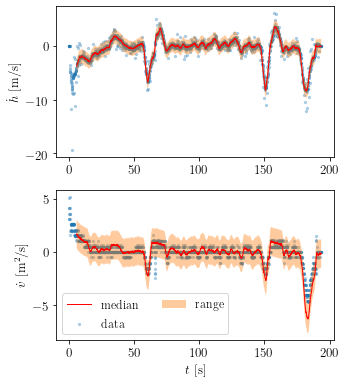

In [13]:
hdw_sim = ysim[:,:,0]
vel_sim = ysim[:,:,1]
h_sim_low = np.quantile(hdw_sim,0.25,axis = 0)
h_sim_up = np.quantile(hdw_sim,0.75,axis = 0)
h_sim_med = np.median(hdw_sim,axis = 0)
v_sim_low = np.quantile(vel_sim,0.25,axis = 0)
v_sim_up = np.quantile(vel_sim,0.75,axis = 0)
v_sim_med = np.median(vel_sim,axis = 0)

yy_map = CAV_4dvdt_2d(tsim, map_point).T

plt.rc('font', size=13)          # controls default text sizes
plt.rc('axes', titlesize=13)     # fontsize of the axes title
plt.rc('axes', labelsize=13)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

matplotlib.rc('text', usetex = True)
fig,axs = plt.subplots(2, 1, figsize=(5,6))
# headway 
axs[0].scatter(tt_single[:-1],data_dh_single,alpha = 0.3,s = 5)
# axs[0].plot(np.tile(tsim, (hdw_sim.shape[0], 1)),hdw_sim,'gray',ls ='-', alpha =0.1,linewidth=0.5)
axs[0].fill_between(tsim,h_sim_low, h_sim_up, alpha=0.4)
axs[0].plot(tsim,h_sim_med,'red', linewidth=1)
# axs[0].plot(tsim,yy_map[:,0],'black',ls ='--', linewidth=2)
axs[0].set_ylabel(r'$\dot{h}\mathrm{\ [m/s]}$')
# axs[0].set_xlim((0,10))
# # velocity
axs[1].scatter(tt_single[:-1],data_dv_single,label = r'$\mathrm{data}$',alpha = 0.3,s = 5)
# axs[1].plot(np.tile(tsim, (vel_sim.shape[0], 1)),vel_sim,'gray',ls ='-', alpha =0.1,linewidth=0.5)
axs[1].fill_between(tsim,v_sim_low, v_sim_up,label = r'$\mathrm{range}$',alpha=0.4)
axs[1].plot(tsim,v_sim_med, 'red', label = r'$\mathrm{median}$',linewidth=1)
# axs[1].plot(tsim,yy_map[:,1],'black',ls ='--', label = r'$\mathrm{MAP\ estimate}$', linewidth=2)
axs[1].set_ylabel(r'$\dot{v}\mathrm{\ [m^2/s]}$')
axs[1].set_xlabel(r'$t\mathrm{\ [s]}$')
# axs[1].set_xlim((0,10))
axs[1].legend(ncol=2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('figures\hstar'+str(h_ave)+'_'+str(dim)+'param_deriv_all.svg')

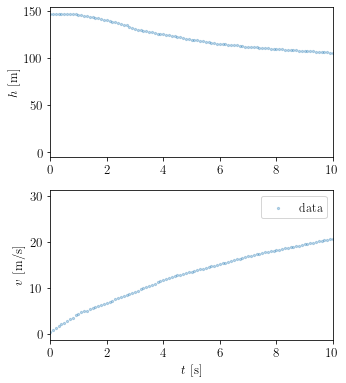

In [27]:
matplotlib.rc('text', usetex = True)
fig,axs = plt.subplots(2, 1, figsize=(5,6))
# headway 
axs[0].scatter(tt_single,data_h_single,alpha = 0.3,s = 5)
# axs[0].plot(np.tile(tsim, (hdw_sim.shape[0], 1)),hdw_sim,'gray',ls ='-', alpha =0.1,linewidth=0.5)
# axs[0].fill_between(tsim,h_sim_low, h_sim_up, alpha=0.4)
# # axs[0].plot(tsim,h_sim_med,'red', linewidth=2)
# axs[0].plot(tsim,yy_map[:,0],'black',ls ='--', linewidth=2)
axs[0].set_ylabel(r'$h\mathrm{\ [m]}$')
axs[0].set_xlim((0,10))
# # velocity
axs[1].scatter(tt_single,data_v_single,label = r'$\mathrm{data}$',alpha = 0.3,s = 5)
# axs[1].plot(np.tile(tsim, (vel_sim.shape[0], 1)),vel_sim,'gray',ls ='-', alpha =0.1,linewidth=0.5)
# axs[1].fill_between(tsim,v_sim_low, v_sim_up,label = r'$\mathrm{500\ simulations}$',alpha=0.4)
# axs[1].plot(tsim,v_sim_med, 'red', label = r'$\mathrm{median}$',linewidth=2)
# axs[1].plot(tsim,yy_map[:,1],'black',ls ='--', label = r'$\mathrm{MAP\ simulation}$', linewidth=2)
axs[1].set_ylabel(r'$v\mathrm{\ [m/s]}$')
axs[1].set_xlabel(r'$t\mathrm{\ [s]}$')
axs[1].set_xlim((0,10))
axs[1].legend(ncol=2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('figures\hstar'+str(h_ave)+'_'+str(dim)+'param_simu_all.svg')

## 500 simulations

In [113]:
# simulation 
dim = 4
h_ave = 30
taumax = 6
fname = 'data\RealAVData\RealAVhstar'+str(h_ave)+'.mat'
data = loadmat(fname)['D']
'''first column is headway of CAV, second column is the speed difference,
third column is the velocity of CAV and last column is the acceleration of CAV.'''
Npts_single = len(data)
dt = 0.1
st = 0
data_h_single = data[st:st+Npts_single,0]                      # inference from h0
data_vl_single = data[st:st+Npts_single,1]+data[st:st+Npts_single,2]  # input to the system
data_v_single = data[st:st+Npts_single,2]                      # or inference from v0
data_dv_single = np.diff(data_v_single)/dt
data_dh_single = np.diff(data_h_single)/dt
tt_single = np.linspace(st*0.1, (st+Npts_single)*0.1, num=Npts_single)  # reference time
tsim = np.linspace(st*0.1+taumax, st*0.1+(Npts_single-1)*0.1, num=Npts_single-1-int(taumax/0.1))   # simulation time
vLfun = lambda t:np.interp(t, tt_single, data_vl_single)
g = lambda t: np.array([np.interp(t, tt_single, data_h_single),np.interp(t, tt_single, data_v_single)])  # history

results_fname = "separate\\power_limit_new\\cba\samples_hdw"+str(h_ave)+"_"+str(dim)+"param.p"
[dram_samples,dram_ar,map_point,cov_laplace] = pickle.load(open(results_fname, "rb" ))
samples_sub = sub_sample_data(dram_samples, frac_burn=0.5, frac_use=0.1)

ysim = np.zeros((np.shape(samples_sub)[0],np.shape(tsim)[0],2))
for i in range(np.shape(samples_sub)[0]):
    ysim[i,:,:] = ddeint(CAV_4param, g, tsim, fargs=samples_sub[i,:].tolist())
    print(i)
results_fname = "separate\\power_limit_new\\cba\part_simulation_hdw"+str(h_ave)+"_4param.p"
pickle.dump([ysim], open(results_fname, "wb" ))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [33]:
h_ave = 50
dim = 4
taumax = 6
fname = 'data\RealAVData\RealAVhstar'+str(h_ave)+'.mat'
data = loadmat(fname)['D']
'''first column is headway of CAV, second column is the speed difference,
third column is the velocity of CAV and last column is the acceleration of CAV.'''
Npts_single = len(data)
dt = 0.1
st = 0
data_h_single = data[st:st+Npts_single,0]                      # inference from h0
data_vl_single = data[st:st+Npts_single,1]+data[st:st+Npts_single,2]  # input to the system
data_v_single = data[st:st+Npts_single,2]                      # or inference from v0
data_dv_single = np.diff(data_v_single)/dt
data_dh_single = np.diff(data_h_single)/dt
tt_single = np.linspace(st*0.1, (st+Npts_single)*0.1, num=Npts_single)  # reference time
tsim = np.linspace(st*0.1+taumax, st*0.1+(Npts_single-1)*0.1, num=Npts_single-1-int(taumax/0.1))   # simulation time
vLfun = lambda t:np.interp(t, tt_single, data_vl_single)
g = lambda t: np.array([np.interp(t, tt_single, data_h_single),np.interp(t, tt_single, data_v_single)])  # history

results_fname = "separate\\power_limit_new\\cba\samples_hdw"+str(h_ave)+"_"+str(dim)+"param.p"
[dram_samples,dram_ar,map_point,cov_laplace] = pickle.load(open(results_fname, "rb" ))
samples_sub = sub_sample_data(dram_samples, frac_burn=0.5, frac_use=0.1)

results_fname = "separate\\power_limit_new\\cba\part_simulation_hdw"+str(h_ave)+"_4param.p"
[ysim] = pickle.load(open(results_fname, "rb" ))

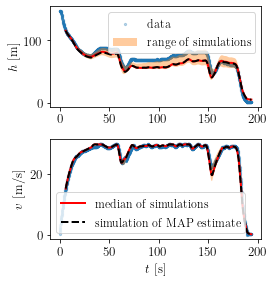

In [36]:
hdw_sim = ysim[:,:,0]
vel_sim = ysim[:,:,1]
h_sim_low = np.quantile(hdw_sim,0,axis = 0)
h_sim_up = np.quantile(hdw_sim,1,axis = 0)
h_sim_med = np.median(hdw_sim,axis = 0)
v_sim_low = np.quantile(vel_sim,0,axis = 0)
v_sim_up = np.quantile(vel_sim,1,axis = 0)
v_sim_med = np.median(vel_sim,axis = 0)

yy_map = ddeint(CAV_4param, g, tsim, fargs=map_point.tolist())

# MSE_h = np.sum((h_sim_med-data_h_single[int(taumax/0.1):-1])**2)/tsim.shape[0]
# MSE_v = np.sum((v_sim_med-data_v_single[int(taumax/0.1):-1])**2)/tsim.shape[0]
plt.rc('font', size=13)          # controls default text sizes
plt.rc('axes', titlesize=13)     # fontsize of the axes title
plt.rc('axes', labelsize=13)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize

matplotlib.rc('text', usetex = True)
fig,axs = plt.subplots(2, 1, figsize=(4,4.5))
# headway 
axs[0].scatter(tt_single,data_h_single,label = r'$\mathrm{data}$',alpha = 0.3,s = 5)
# axs[0].plot(np.tile(tsim, (hdw_sim.shape[0], 1)),hdw_sim,'gray',ls ='-', alpha =0.1,linewidth=0.5)
axs[0].fill_between(tsim,h_sim_low, h_sim_up, label = r'$\mathrm{range\ of\ simulations}$',alpha=0.4)
axs[0].plot(tsim,h_sim_med,'red', linewidth=2)
axs[0].plot(tsim,yy_map[:,0],'black',ls ='--', linewidth=2)
axs[0].set_ylabel(r'$h\mathrm{\ [m]}$')
axs[0].legend(ncol=1)
# # velocity
axs[1].scatter(tt_single,data_v_single,alpha = 0.3,s = 5)
# axs[1].plot(np.tile(tsim, (vel_sim.shape[0], 1)),vel_sim,'gray',ls ='-', alpha =0.1,linewidth=0.5)
axs[1].fill_between(tsim,v_sim_low, v_sim_up,alpha=0.4)
axs[1].plot(tsim,v_sim_med, 'red', label = r'$\mathrm{median\ of\ simulations}$',linewidth=2)
axs[1].plot(tsim,yy_map[:,1],'black',ls ='--', label = r'$\mathrm{simulation\ of\ MAP\ estimate}$', linewidth=2)
axs[1].set_ylabel(r'$v\mathrm{\ [m/s]}$')
axs[1].set_xlabel(r'$t\mathrm{\ [s]}$')
axs[1].legend(ncol=1)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('figures\hstar'+str(h_ave)+'_'+str(dim)+'param_simu_all.svg')

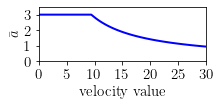

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(3, 1))
x = np.linspace(0.01, 30, 100)
# p = lambda v: 0.3*0.001*v**2+0.1*0.01*v+0.1
ax.plot(x, satfun(amax,x),'b-', lw=2)
# ax.plot(x, p(x), lw=2, alpha=0.6)
# ax.set_title('Gamma Prior')
ax.set_xlabel(r'$\mathrm{velocity\ value}$')
ax.set_ylabel(r'$\bar{a}$')
ax.set_ylim((0,3.5))
ax.set_xlim((0,30))
ax.set_xticks((0,5,10,15,20,25,30))
ax.set_yticks((0,1,2,3))
plt.savefig('figures\\velocity.svg')

(0.7510451500836763, 0.37077933501801297)


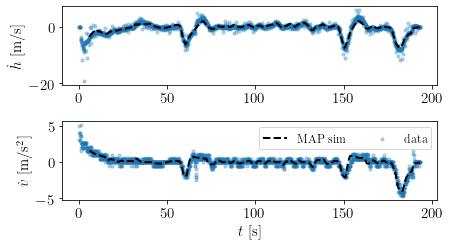

In [52]:
fig,axs = plt.subplots(2, 1, figsize=(6.5, 4))
# headway 
axs[0].scatter(tt[:-1],data_dh, label = 'data',alpha = 0.3,s = 10)
axs[0].plot(tsim[:-1],np.diff(yy_map[:,0])/dt,'black',ls ='--', label = 'MAP simulation',linewidth=2)
axs[0].set_ylabel(r'$\dot{h}\mathrm{\ [m/s]}$')
# velocity
axs[1].scatter(tt[:-1],data_dv,label = r'$\mathrm{data}$',alpha = 0.3,s = 10)
axs[1].set_ylabel(r'$\dot{v}\mathrm{\ [m/s^2]}$')
axs[1].plot(tsim[:-1],np.diff(yy_map[:,1])/dt, 'black', ls ='--',label = r'$\mathrm{MAP\ sim}$',linewidth=2)
axs[1].set_xlabel(r'$t\mathrm{\ [s]}$')
# axs[1].set_title(r'$h^*$ = {} m; mean $MSE_h$ = {:.3f},$MSE_v$ = {:.3f}; MAP $MSE_h$ = {:.3f},$MSE_v$ = {:.3f}'.format(h_ave, MSE_h,MSE_v,MSE_h_map,MSE_v_map))
axs[1].legend(ncol=2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

MSE_dh_map = np.sum((np.diff(yy_map[:,0])/dt-data_dh[int(taumax/0.1):-1])**2)/(yy_map.shape[0]-1)
MSE_dv_map = np.sum((np.diff(yy_map[:,1])/dt-data_dv[int(taumax/0.1):-1])**2)/(yy_map.shape[0]-1)
print((np.sqrt(MSE_dh_map),np.sqrt(MSE_dv_map)))

(0.5712399006700619, 0.5219627791578694)


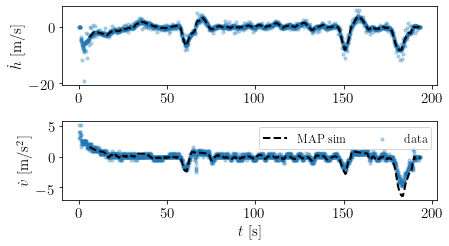

In [53]:
fig,axs = plt.subplots(2, 1, figsize=(6.5, 4))
tsim = np.arange(taumax, (Npts-1)*0.1, 0.1)
static_mapping = CAV_4dvdt_2d(tsim, map_point)
# headway 
axs[0].scatter(tt[:-1],data_dh, label = 'data',alpha = 0.3,s = 10)
axs[0].plot(tsim,static_mapping[0,:],'black',ls ='--', label = 'MAP simulation',linewidth=2)
axs[0].set_ylabel(r'$\dot{h}\mathrm{\ [m/s]}$')
# velocity
axs[1].scatter(tt[:-1],data_dv,label = r'$\mathrm{data}$',alpha = 0.3,s = 10)
axs[1].set_ylabel(r'$\dot{v}\mathrm{\ [m/s^2]}$')
axs[1].plot(tsim,static_mapping[1,:], 'black', ls ='--',label = r'$\mathrm{MAP\ sim}$',linewidth=2)
axs[1].set_xlabel(r'$t\mathrm{\ [s]}$')
# axs[1].set_title(r'$h^*$ = {} m; mean $MSE_h$ = {:.3f},$MSE_v$ = {:.3f}; MAP $MSE_h$ = {:.3f},$MSE_v$ = {:.3f}'.format(h_ave, MSE_h,MSE_v,MSE_h_map,MSE_v_map))
axs[1].legend(ncol=2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

MSE_dh_map = np.sum((static_mapping[0,:]-data_dh[int(taumax/0.1):])**2)/(static_mapping.shape[1]-1)
MSE_dv_map = np.sum((static_mapping[1,:]-data_dv[int(taumax/0.1):])**2)/(static_mapping.shape[1]-1)
print((np.sqrt(MSE_dh_map),np.sqrt(MSE_dv_map)))

(0.7055294848920532, 0.3682250066459558)


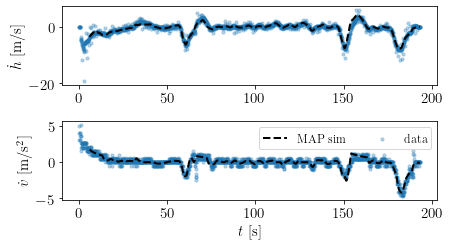

In [46]:
fig,axs = plt.subplots(2, 1, figsize=(6.5, 4))
# headway 
axs[0].scatter(tt[:-1],data_dh, label = 'data',alpha = 0.3,s = 10)
axs[0].plot(tsim[:-1],np.diff(yy_map[:,0])/dt,'black',ls ='--', label = 'MAP simulation',linewidth=2)
axs[0].set_ylabel(r'$\dot{h}\mathrm{\ [m/s]}$')
# velocity
axs[1].scatter(tt[:-1],data_dv,label = r'$\mathrm{data}$',alpha = 0.3,s = 10)
axs[1].set_ylabel(r'$\dot{v}\mathrm{\ [m/s^2]}$')
axs[1].plot(tsim[:-1],np.diff(yy_map[:,1])/dt, 'black', ls ='--',label = r'$\mathrm{MAP\ sim}$',linewidth=2)
axs[1].set_xlabel(r'$t\mathrm{\ [s]}$')
# axs[1].set_title(r'$h^*$ = {} m; mean $MSE_h$ = {:.3f},$MSE_v$ = {:.3f}; MAP $MSE_h$ = {:.3f},$MSE_v$ = {:.3f}'.format(h_ave, MSE_h,MSE_v,MSE_h_map,MSE_v_map))
axs[1].legend(ncol=2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

MSE_dh_map = np.sum((np.diff(yy_map[:,0])/dt-data_dh[int(taumax/0.1):-1])**2)/(yy_map.shape[0]-1)
MSE_dv_map = np.sum((np.diff(yy_map[:,1])/dt-data_dv[int(taumax/0.1):-1])**2)/(yy_map.shape[0]-1)
print((np.sqrt(MSE_dh_map),np.sqrt(MSE_dv_map)))

(0.5712399006700619, 0.4966480776364407)


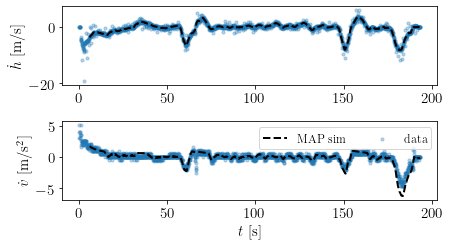

In [48]:
fig,axs = plt.subplots(2, 1, figsize=(6.5, 4))
tsim = np.arange(taumax, (Npts-1)*0.1, 0.1)
static_mapping = CAV_4dvdt_2d(tsim, map_point)
# headway 
axs[0].scatter(tt[:-1],data_dh, label = 'data',alpha = 0.3,s = 10)
axs[0].plot(tsim,static_mapping[0,:],'black',ls ='--', label = 'MAP simulation',linewidth=2)
axs[0].set_ylabel(r'$\dot{h}\mathrm{\ [m/s]}$')
# velocity
axs[1].scatter(tt[:-1],data_dv,label = r'$\mathrm{data}$',alpha = 0.3,s = 10)
axs[1].set_ylabel(r'$\dot{v}\mathrm{\ [m/s^2]}$')
axs[1].plot(tsim,static_mapping[1,:], 'black', ls ='--',label = r'$\mathrm{MAP\ sim}$',linewidth=2)
axs[1].set_xlabel(r'$t\mathrm{\ [s]}$')
# axs[1].set_title(r'$h^*$ = {} m; mean $MSE_h$ = {:.3f},$MSE_v$ = {:.3f}; MAP $MSE_h$ = {:.3f},$MSE_v$ = {:.3f}'.format(h_ave, MSE_h,MSE_v,MSE_h_map,MSE_v_map))
axs[1].legend(ncol=2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

MSE_dh_map = np.sum((static_mapping[0,:]-data_dh[int(taumax/0.1):])**2)/(static_mapping.shape[1]-1)
MSE_dv_map = np.sum((static_mapping[1,:]-data_dv[int(taumax/0.1):])**2)/(static_mapping.shape[1]-1)
print((np.sqrt(MSE_dh_map),np.sqrt(MSE_dv_map)))

## Static error

In [325]:
## plot the difference between dataset and different dim
# ave lead velocity  2.0, 6.3, 11.4, 14.5, 17.1, 21.7, 20.9, 22.0, 22.3, 25.1
# ave velocity       2.0, 6.5, 11.7, 14.8, 17.6, 22.1, 21.4, 22.8, 23.4, 25.8
# ave headway        8.0, 16.7, 25.6, 30.7,35.7, 44.8, 44.5, 49.7, 52.7, 72.4 (acceleration limit is nonlinear)
h_collect = (5,10,15,20,25,30,50)
N = np.shape(h_collect)
v_mean = np.zeros(N)
h_mean = np.zeros(N)

dim = 4
N = len(h_collect)
Median_all4 = np.zeros((N,dim))
MAP_all4 = np.zeros((N,dim))
RMSE_dh_median4= np.zeros(N)
RMSE_dv_median4= np.zeros(N)
RMSE_dh_map4= np.zeros(N)
RMSE_dv_map4= np.zeros(N)

dim = 3
Median_all3 = np.zeros((N,dim))
MAP_all3 = np.zeros((N,dim))
RMSE_dh_median3= np.zeros(N)
RMSE_dv_median3= np.zeros(N)
RMSE_dh_map3= np.zeros(N)
RMSE_dv_map3= np.zeros(N)

dim = 2
Median_all2 = np.zeros((N,dim))
MAP_all2 = np.zeros((N,dim))
RMSE_dh_median2= np.zeros(N)
RMSE_dv_median2= np.zeros(N)
RMSE_dh_map2= np.zeros(N)
RMSE_dv_map2= np.zeros(N)



i = 0
for h in h_collect:
    fname = 'data\RealAVData\RealAVhstar'+str(h)+'.mat'
    data = loadmat(fname)['D']
    Npts = len(data)
    dt = 0.1
    st = 0
    data_h = data[st:st+Npts,0]                      # inference from h0
    data_vl = data[st:st+Npts,1]+data[st:st+Npts,2]  # input to the system
    data_v = data[st:st+Npts,2]                      # or inference from v0
    tt = np.linspace(st*0.1, (st+Npts)*0.1, num=Npts)  # reference time
    tsim = np.linspace(st*0.1+taumax, st*0.1+(Npts-1)*0.1, num=Npts-1-int(taumax/0.1))   # simulation time
    observe_fun = lambda t:np.array([np.interp(t, tt, data_h),np.interp(t, tt, data_v),np.interp(t, tt, data_vl)])
#     vLfun = lambda t:np.interp(t, tt, data_vl)
#     g = lambda t: np.array([np.interp(t, tt, data_h),np.interp(t, tt, data_v)])  # history
    data_dv = np.diff(data_v)/dt
    data_dh = np.diff(data_h)/dt
    v_mean[i] = np.mean(data_v)
    h_mean[i] = np.mean(data_h)
    
    results_fname = "separate\\power_limit_new\\cba\samples_hdw"+str(h)+"_4param.p"
    [dram_samples,dram_ar,map_point,cov_laplace] = pickle.load(open(results_fname, "rb" ))
    print('v_mean:', v_mean[i],'\n cba, AR: ', dram_ar)
    samples_sub = sub_sample_data(dram_samples, frac_burn=0.5, frac_use=0.7)
    Median_all4[i,:] = np.median(samples_sub,axis = 0)
    print(Median_all4[i,0])
    MAP_all4[i,:] = map_point
    yy_median_st = CAV_4dvdt_2d(tsim, Median_all4[i,:])
    yy_map_st = CAV_4dvdt_2d(tsim, map_point)
    RMSE_dh_median4[i] = np.sqrt(np.sum((yy_median_st[0,:]-data_dh[int(taumax/0.1):])**2)/tsim.shape)
    RMSE_dv_median4[i] = np.sqrt(np.sum((yy_median_st[1,:]-data_dv[int(taumax/0.1):])**2)/tsim.shape)
    RMSE_dh_map4[i] = np.sqrt(np.sum((yy_map_st[0,:]-data_dh[int(taumax/0.1):])**2)/tsim.shape)
    RMSE_dv_map4[i] = np.sqrt(np.sum((yy_map_st[1,:]-data_dv[int(taumax/0.1):])**2)/tsim.shape)
    
    results_fname = "separate\\power_limit_new\\ca\samples_hdw"+str(h)+"_3param.p"
    [dram_samples,dram_ar,map_point,cov_laplace] = pickle.load(open(results_fname, "rb" ))
    print(' ca, AR: ', dram_ar)
    samples_sub = sub_sample_data(dram_samples, frac_burn=0.5, frac_use=0.7)
    Median_all3[i,:] = np.median(samples_sub,axis = 0)
    MAP_all3[i,:] = map_point
    yy_median_st = CAV_3dvdt_2d(tsim, Median_all3[i,:])
    yy_map_st = CAV_3dvdt_2d(tsim, map_point)
    RMSE_dh_median3[i] = np.sqrt(np.sum((yy_median_st[0,:]-data_dh[int(taumax/0.1):])**2)/tsim.shape)
    RMSE_dv_median3[i] = np.sqrt(np.sum((yy_median_st[1,:]-data_dv[int(taumax/0.1):])**2)/tsim.shape)
    RMSE_dh_map3[i] = np.sqrt(np.sum((yy_map_st[0,:]-data_dh[int(taumax/0.1):])**2)/tsim.shape)
    RMSE_dv_map3[i] = np.sqrt(np.sum((yy_map_st[1,:]-data_dv[int(taumax/0.1):])**2)/tsim.shape)
    
    results_fname = "separate\\power_limit_new\\c\samples_hdw"+str(h)+"_2param.p"
    [dram_samples,dram_ar,map_point,cov_laplace] = pickle.load(open(results_fname, "rb" ))
    print(' c, AR: ', dram_ar)
    samples_sub = sub_sample_data(dram_samples, frac_burn=0.5, frac_use=0.7)
    Median_all2[i,:] = np.median(samples_sub,axis = 0)
    MAP_all2[i,:] = map_point
    yy_median_st = CAV_2dvdt_2d(tsim, Median_all2[i,:])
    yy_map_st = CAV_2dvdt_2d(tsim, map_point)
    RMSE_dh_median2[i] = np.sqrt(np.sum((yy_median_st[0,:]-data_dh[int(taumax/0.1):])**2)/tsim.shape)
    RMSE_dv_median2[i] = np.sqrt(np.sum((yy_median_st[1,:]-data_dv[int(taumax/0.1):])**2)/tsim.shape)
    RMSE_dh_map2[i] = np.sqrt(np.sum((yy_map_st[0,:]-data_dh[int(taumax/0.1):])**2)/tsim.shape)
    RMSE_dv_map2[i] = np.sqrt(np.sum((yy_map_st[1,:]-data_dv[int(taumax/0.1):])**2)/tsim.shape)
    i = i+1


v_mean: 2.033521695257316 
 cba, AR:  0.5001500150015001
0.5797760450347611
 ca, AR:  0.5613561356135613
 c, AR:  0.6142614261426143
v_mean: 6.543597194388778 
 cba, AR:  0.555055505550555
0.6025048915078439
 ca, AR:  0.6101610161016101
 c, AR:  0.7152715271527152
v_mean: 11.72158131176999 
 cba, AR:  0.5005500550055005
0.7159673434670646
 ca, AR:  0.5589558955895589
 c, AR:  0.6342634263426342
v_mean: 14.852660606060606 
 cba, AR:  0.4673467346734673
0.7452648191545745
 ca, AR:  0.48974897489748975
 c, AR:  0.5901590159015901
v_mean: 17.56482084690554 
 cba, AR:  0.5252525252525253
0.6810128017355341
 ca, AR:  0.5852585258525853
 c, AR:  0.6437643764376437
v_mean: 22.14625687156422 
 cba, AR:  0.5083508350835083
0.5676705796190443
 ca, AR:  0.5728572857285729
 c, AR:  0.6120612061206121
v_mean: 25.84456611570248 
 cba, AR:  0.5531553155315532
0.5673096214652582
 ca, AR:  0.6064606460646065
 c, AR:  0.7101710171017102


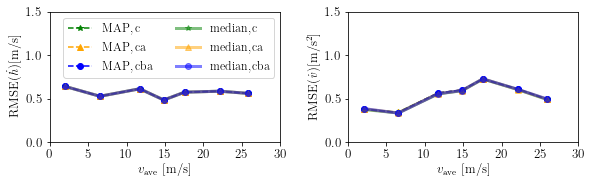

In [326]:
plt.rc('font', size=13)          # controls default text sizes
plt.rc('axes', titlesize=13)     # fontsize of the axes title
plt.rc('axes', labelsize=13)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
fig, axs = plt.subplots(1, 2, figsize=(8.5, 3))
axs[0].plot(v_mean, RMSE_dh_map2,'green',ls='--',marker = '*',label='$\mathrm{MAP, c}$')
axs[0].plot(v_mean, RMSE_dh_map3,'orange',ls='--',marker = '^',label='$\mathrm{MAP, ca}$')
axs[0].plot(v_mean, RMSE_dh_map4,'blue',ls='--',marker = 'o',label='$\mathrm{MAP, cba}$')
axs[0].plot(v_mean, RMSE_dh_median2,'green',linewidth=3, alpha=0.5,marker = '*',label='$\mathrm{median, c}$')
axs[0].plot(v_mean, RMSE_dh_median3,'orange',linewidth=3, alpha=0.5,marker = '^',label='$\mathrm{median, ca}$')
axs[0].plot(v_mean, RMSE_dh_median4,'blue',linewidth=3, alpha=0.5,marker = 'o',label='$\mathrm{median, cba}$')
axs[0].set_xlim([0,28])
axs[0].set_xticks((0,5,10,15,20,25,30))
axs[0].set_ylim([0,1.5])
axs[0].legend(ncol = 2)
axs[0].set_xlabel(r'$v_{\rm ave}$ $\mathrm{[m/s]}$')
axs[0].set_ylabel('$\mathrm{RMSE(\mathit{\dot{h}}) [m/s]}$')

axs[1].plot(v_mean, RMSE_dv_map2,'green',ls='--',marker = '*',label='$\mathrm{MAP, c}$')
axs[1].plot(v_mean, RMSE_dv_map3,'orange',ls='--',marker = '^',label='$\mathrm{MAP, ca}$')
axs[1].plot(v_mean, RMSE_dv_map4,'blue',ls='--',marker = 'o',label='$\mathrm{MAP, cba}$')
axs[1].plot(v_mean, RMSE_dv_median2,'green',marker = '*',linewidth=3, alpha=0.5,label='$\mathrm{median, c}$')
axs[1].plot(v_mean, RMSE_dv_median3,'orange',marker = '^',linewidth=3, alpha=0.5,label='$\mathrm{median, ca}$')
axs[1].plot(v_mean, RMSE_dv_median4,'blue',marker = 'o',linewidth=3, alpha=0.5,label='$\mathrm{median, cba}$')
axs[1].set_xlim([0,28])
axs[1].set_xticks((0,5,10,15,20,25,30))
axs[1].set_ylim([0,1.5])
axs[1].set_ylabel(r'$\mathrm{RMSE(\mathit{\dot{v}}) [m/s^2]}$')
axs[1].set_xlabel(r'$v_{\rm ave}$ $\mathrm{[m/s]}$')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('figures\RMSE_sep.svg')

## simulations